# Federated Learning Implementation with tensorflow



In [1]:
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from sklearn.metrics import precision_score,recall_score, accuracy_score,confusion_matrix,f1_score
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History

import pandas as pd



C:\Users\riash\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [19]:
### Train/Test Data seperation

file_out = pd.read_csv('Data/adult_processed.csv')
file_out_repaired = pd.read_csv('Data/train_data_repaired.csv')
cols = []
cols_train = []
for i in list(file_out.columns):
    if  i != 'income':
        cols.append(i)
        
for i in list(file_out_repaired.columns):
    if  i != 'income':
        cols_train.append(i)

feature_set1 = pd.read_csv('Data/train_data_repaired.csv')
feature_set2 = pd.read_csv('Data/test.csv')

x = feature_set1[cols_train].copy().values
y = feature_set1[['income']].copy().values
        
sc = StandardScaler()
X_train = sc.fit_transform(x)
y_train = y

x2 = feature_set2[cols].copy().values
y2 = feature_set2[['income']].copy().values
        
X_test = sc.fit_transform(x2)
y_test = y2


# X_test.shape, y_test.shape 
if cols == cols_train:
    print("yes")
# diff = np.setdiff1d(cols_train,cols)
# diff

yes


In [20]:
# gender split

dict_users = {i: np.array([]) for i in range(10)}
data_out = []

def create_hetero_clients( image_list, label_list, start_client = 0, num_clients=10, initial='clients'):
    
    selected_inds = []

    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]
    
    data_out = data
    
    num_shards, num_imgs = int(len(image_list)/30), 30
    idx_shard = [i for i in range(num_shards)]

    min_shard = 1
    max_shard = 60  #953/15 = 63.53
    
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=(num_clients-start_client))
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)


    if sum(random_shard_size) > num_shards:
        
        for i in range(start_client, num_clients):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(start_client, num_clients):
            if len(idx_shard) == 0:
                continue
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

    else:

        for i in range(start_client, num_clients):
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
#             shard_size = random_shard_size[int(i/len(random_shard_size)) - 1]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[k]) == 0):
                    dict_users[k] = data[ind1: ind2]
                else:
                    dict_users[k] = np.concatenate(
                    (dict_users[k],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])
                
                
    return dict_users, selected_inds, data_out



In [21]:
# dict_users = {i: np.array([]) for i in range(4)}

def create_client_iid(image_list, label_list, client_num):    
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]
    
    dict_users[client_num] = data
    
    return dict_users

In [22]:
def initializer_income():
    
    x_feats = feature_set1[cols_train].copy().values
    y_feats = feature_set1[['income']].copy().values

    X_train_new = sc.fit_transform(x_feats)
    y_train_new = y_feats

    
    return [X_train_new, y_train_new]

In [23]:
def get_hetero_clients_gender(train_sets):
    
    data = list(zip(train_sets[0], train_sets[1]))
    random.shuffle(data)
    
#     print(type(train_sets), type(train_sets[0]),type(list(list(zip(*data))[0]) ), type(data))
    
    train_sets[0] = list(list(zip(*data))[0])
    train_sets[1] = list(list(zip(*data))[1])
    
    
    # NON_IID
    clients, inds, data_out1 = create_hetero_clients(train_sets[0], train_sets[1], start_client = 0, num_clients=10, initial='client') 
    
    

# #     IID
#     clients = create_client_iid(train_sets[0], train_sets[1], 0)
    
#     clients2 = create_client_iid(train_sets[2], train_sets[3], 1)
#     clients = {**clients, **clients2}
    
#     clients3 = create_client_iid(train_sets[4], train_sets[5], 2)
#     clients = {**clients, **clients3}
    
#     clients4 = create_client_iid(train_sets[6], train_sets[7], 3)
#     clients = {**clients, **clients4}
    

    
    return clients


In [24]:
# take bs = 128 for 5 clients and 10 rounds
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    data = []
    label = []
    for x in data_shard:
        data.append(x[0])
        label.append(x[1])
    #seperate shard into data and labels lists
#     data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
#     print( label[0])
    return dataset.shuffle(len(label)).batch(bs)

In [25]:

#process and batch the training data for each client
def batch_clients(clients):
    clients_batched = dict()
    for (client_name, data) in clients.items():
#         print("data ",len(data))
        clients_batched[client_name] = batch_data(data,126)#non-IID
#         clients_batched[client_name] = batch_data(data,1) #IID
    

    #process and batch the test set  
    test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
    
#     test_batched
    return clients_batched, test_batched


In [26]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes=2 , learning_rate = 0.001, metric = "accuracy"):

        model = Sequential()
        
        model.add(Dense(128, input_shape = (shape,)))
#         model.add(Dense(128, Activation("relu")))
#         model.add(Dense(64, Activation("relu")))
#         model.add(Dense(32, Activation("relu")))
#         model.add(Dense(1))
        
        model.add(Dense(128, Activation("tanh")))
        model.add(Dense(64, Activation("tanh")))
        model.add(Dense(32, Activation("tanh")))
        model.add(Dense(1,Activation('sigmoid')))
        


        return model

In [27]:
lr = 0.005
comms_round = 10
loss=tf.keras.losses.BinaryCrossentropy(from_logits = False)

metrics = ['binary_accuracy']

optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.5
               )     



In [28]:


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
#     print(len(scaled_weight_list))
    for grad_list_tuple in zip(*scaled_weight_list):
#         print(len(grad_list_tuple))
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    
#     cce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#     cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    logits = model.predict(X_test)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    acc = score[1] ; loss = score[0]
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))

    return acc, loss

In [29]:

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(X_train.shape[1] ,classes=2)
global_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
# clients_batched, test_batched = batch_clients(clients)
# client_names= list(clients_batched.keys())
# client_names = [0, 1, 2, 3, 4, 5, 6, 7]
client_names = [0, 1,2,3,4,5,6,7,8,9]
# print(client_names, "asugdefbh")
# print(clients_batched)
global_loss_list = []
global_freq_list = []
global_acc_list = []
client_loss = {i: np.array([]) for i in range(len(client_names))}
client_accuracy = {i: np.array([]) for i in range(len(client_names))}
client_frequency = {i: np.array([]) for i in range(len(client_names))}

train_sets = initializer_income()
# train_sets = initializer_income_race_gender()

# print(len(train_sets))
#commence global training loop
for comm_round in range(comms_round):
    epoch_freq = 0
#     clients = create_clients(X_train, y_train, num_clients=15, initial='client')
#     clients = get_hetero_clients()
    clients = get_hetero_clients_gender(list(train_sets) )
#     clients = get_hetero_clients_gender_race(list(train_sets) )
#     print("client0: ", clients[0])

    clients_batched, test_batched = batch_clients(clients)
#     print("client batched 0: ", clients_batched[1])
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
#     print(client_names)
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(X_train.shape[1],classes=2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        history = local_model.fit(clients_batched[client], epochs=1, verbose=1)
        
#         get client acc, loss
#         print(client)
        if(len(client_loss[client])== 0):
            client_loss[client] = [history.history['loss'][0]]
            client_accuracy[client] = [history.history['binary_accuracy'][0]]
            client_frequency[client] = [len(clients_batched[client])]
        
        else:
            client_loss[client] = np.append(client_loss[client], (history.history['loss'][0]))
            client_frequency[client] = np.append(client_frequency[client], len(clients_batched[client]))
            client_accuracy[client] = np.append(client_accuracy[client], (history.history['binary_accuracy'][0]))
        
        epoch_freq += len(clients_batched[client])
        
        print("client", client, "loss -->" ,client_loss[client], "freq->", client_frequency[client], "accuracy->", client_accuracy[client])
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    
    global_freq_list.append(epoch_freq)
    epoch_freq = 0
    

#     test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_loss_list.append(global_loss)
        global_acc_list.append(global_acc)
        
        print("global_loss_list: ", global_loss_list )
        print("global_acc_list: ", global_acc_list )
        print("global_freq_list: ", global_freq_list)



<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2/2 [==============================] - 0s 0s/step - loss: 0.6718 - binary_accuracy: 0.6067
client 7 loss --> [0.6717818379402161] freq-> [2] accuracy-> [0.6066666841506958]
49/49 [==============================] - 0s 2ms/step - loss: 0.5920 - binary_accuracy: 0.7089
client 3 loss --> [0.5920248031616211] freq-> [49] accuracy-> [0.7089108824729919]
23/23 [==============================] - 0s 2ms/step - loss: 0.6304 - binary_accuracy: 0.6537
client 6 loss --> [0.6303593516349792] freq-> [23] accuracy-> [0.6536841988563538]
50/50 [==============================] - 0s 2ms/step - loss: 0.5832 - binary_accuracy: 0.7260
client 9 loss --> [0.5831888914108276] freq-> [50] accuracy-> [0.7260317206382751]
11/11 [==============================] - 0s 3ms/step - loss: 0.6583 - binary_accuracy: 0.6068
client 4 loss --> [0.6582658886909485] freq-> [11] accuracy-> [0.6068181991577148]
26/26 [==============================] - 0s 3ms/step - loss: 0.6263 - binary_accuracy: 0.6489
client 2 loss --> [0.6262

91/91 [==============================] - 0s 2ms/step - loss: 0.3846 - binary_accuracy: 0.8330
client 7 loss --> [0.67178184 0.51838964 0.42784214 0.38460797] freq-> [ 2 27 40 91] accuracy-> [0.60666668 0.79030305 0.82404041 0.83298153]
135/135 [==============================] - 0s 2ms/step - loss: 0.3803 - binary_accuracy: 0.8372
client 6 loss --> [0.63035935 0.5015859  0.4151603  0.3802737 ] freq-> [ 23  48  91 135] accuracy-> [0.6536842  0.79149997 0.83095866 0.83722717]
190/190 [==============================] - 0s 2ms/step - loss: 0.3771 - binary_accuracy: 0.8350
client 5 loss --> [0.61959428 0.48596308 0.40170121 0.37713358] freq-> [ 31  74 155 190] accuracy-> [0.66692913 0.80526882 0.82871795 0.83496648]
182/182 [==============================] - 0s 2ms/step - loss: 0.3768 - binary_accuracy: 0.8375
client 9 loss --> [0.58318889 0.45914096 0.40776464 0.37675032] freq-> [ 50 120 150 182] accuracy-> [0.72603172 0.8139165  0.82998937 0.8375383 ]
119/119 [=============================

345/345 [==============================] - 1s 3ms/step - loss: 0.3460 - binary_accuracy: 0.8427
client 5 loss --> [0.61959428 0.48596308 0.40170121 0.37713358 0.3615804  0.35094073
 0.34597063] freq-> [ 31  74 155 190 254 301 345] accuracy-> [0.66692913 0.80526882 0.82871795 0.83496648 0.83968699 0.84224683
 0.84266943]
185/185 [==============================] - 0s 2ms/step - loss: 0.3549 - binary_accuracy: 0.8373
client 3 loss --> [0.5920248  0.47583362 0.42313868 0.3866969  0.37091368 0.36190581
 0.35488188] freq-> [ 49 102 104 119 124 138 185] accuracy-> [0.70891088 0.80850899 0.8235566  0.83092368 0.83423078 0.83580887
 0.83733851]
270/270 [==============================] - 1s 2ms/step - loss: 0.3486 - binary_accuracy: 0.8430
client 9 loss --> [0.58318889 0.45914096 0.40776464 0.37675032 0.36124367 0.35230872
 0.34864539] freq-> [ 50 120 150 182 203 236 270] accuracy-> [0.72603172 0.8139165  0.82998937 0.8375383  0.84057969 0.84284753
 0.84299177]
209/209 [=========================

215/215 [==============================] - 1s 4ms/step - loss: 0.3435 - binary_accuracy: 0.8434
client 8 loss --> [0.58725697 0.49155888 0.41370627 0.38253722 0.36716944 0.35897282
 0.35035193 0.34639585 0.34351107] freq-> [ 51  64 112 133 145 158 187 200 215] accuracy-> [0.71806854 0.80588973 0.82985073 0.83530468 0.83838552 0.83816719
 0.84089172 0.84224343 0.84337038]
287/287 [==============================] - 1s 3ms/step - loss: 0.3433 - binary_accuracy: 0.8454
client 6 loss --> [0.63035935 0.5015859  0.4151603  0.3802737  0.36296323 0.35536006
 0.35027575 0.3468076  0.34330562] freq-> [ 23  48  91 135 164 209 225 248 287] accuracy-> [0.6536842  0.79149997 0.83095866 0.83722717 0.84047621 0.84233409
 0.84359521 0.84452999 0.84544194]
456/456 [==============================] - 1s 3ms/step - loss: 0.3417 - binary_accuracy: 0.8432
client 5 loss --> [0.61959428 0.48596308 0.40170121 0.37713358 0.3615804  0.35094073
 0.34597063 0.34304726 0.34170884] freq-> [ 31  74 155 190 254 301 345 

310/310 [==============================] - 1s 2ms/step - loss: 0.3404 - binary_accuracy: 0.8433
client 0 loss --> [0.61086375 0.48895925 0.42192078 0.38538462 0.36777058 0.35811067
 0.35217971 0.34762534 0.34223405 0.34042257] freq-> [ 34  63  89  99 135 136 155 198 253 310] accuracy-> [0.68465227 0.80593437 0.82598567 0.83244336 0.83575219 0.83884007
 0.84030771 0.84148592 0.84315759 0.84329736]
comm_round: 9 | global_acc: 83.354% | global_loss: 0.364362895488739
global_loss_list:  [0.5603388547897339, 0.4609312415122986, 0.4132608473300934, 0.3915412425994873, 0.3802947700023651, 0.37398862838745117, 0.37006595730781555, 0.3675161898136139, 0.36569684743881226, 0.364362895488739]
global_acc_list:  [0.75655198097229, 0.8110155463218689, 0.8226863145828247, 0.8266789317131042, 0.8291359543800354, 0.8310810923576355, 0.8311834335327148, 0.8326166868209839, 0.8330262303352356, 0.8335380554199219]
global_freq_list:  [315, 624, 935, 1246, 1554, 1864, 2175, 2485, 2795, 3105]


client_ 0  loss:  [0.61086375 0.48895925 0.42192078 0.38538462 0.36777058 0.35811067
 0.35217971 0.34762534 0.34223405 0.34042257] freq:  [ 34  63  89  99 135 136 155 198 253 310] acc [0.68465227 0.80593437 0.82598567 0.83244336 0.83575219 0.83884007
 0.84030771 0.84148592 0.84315759 0.84329736]


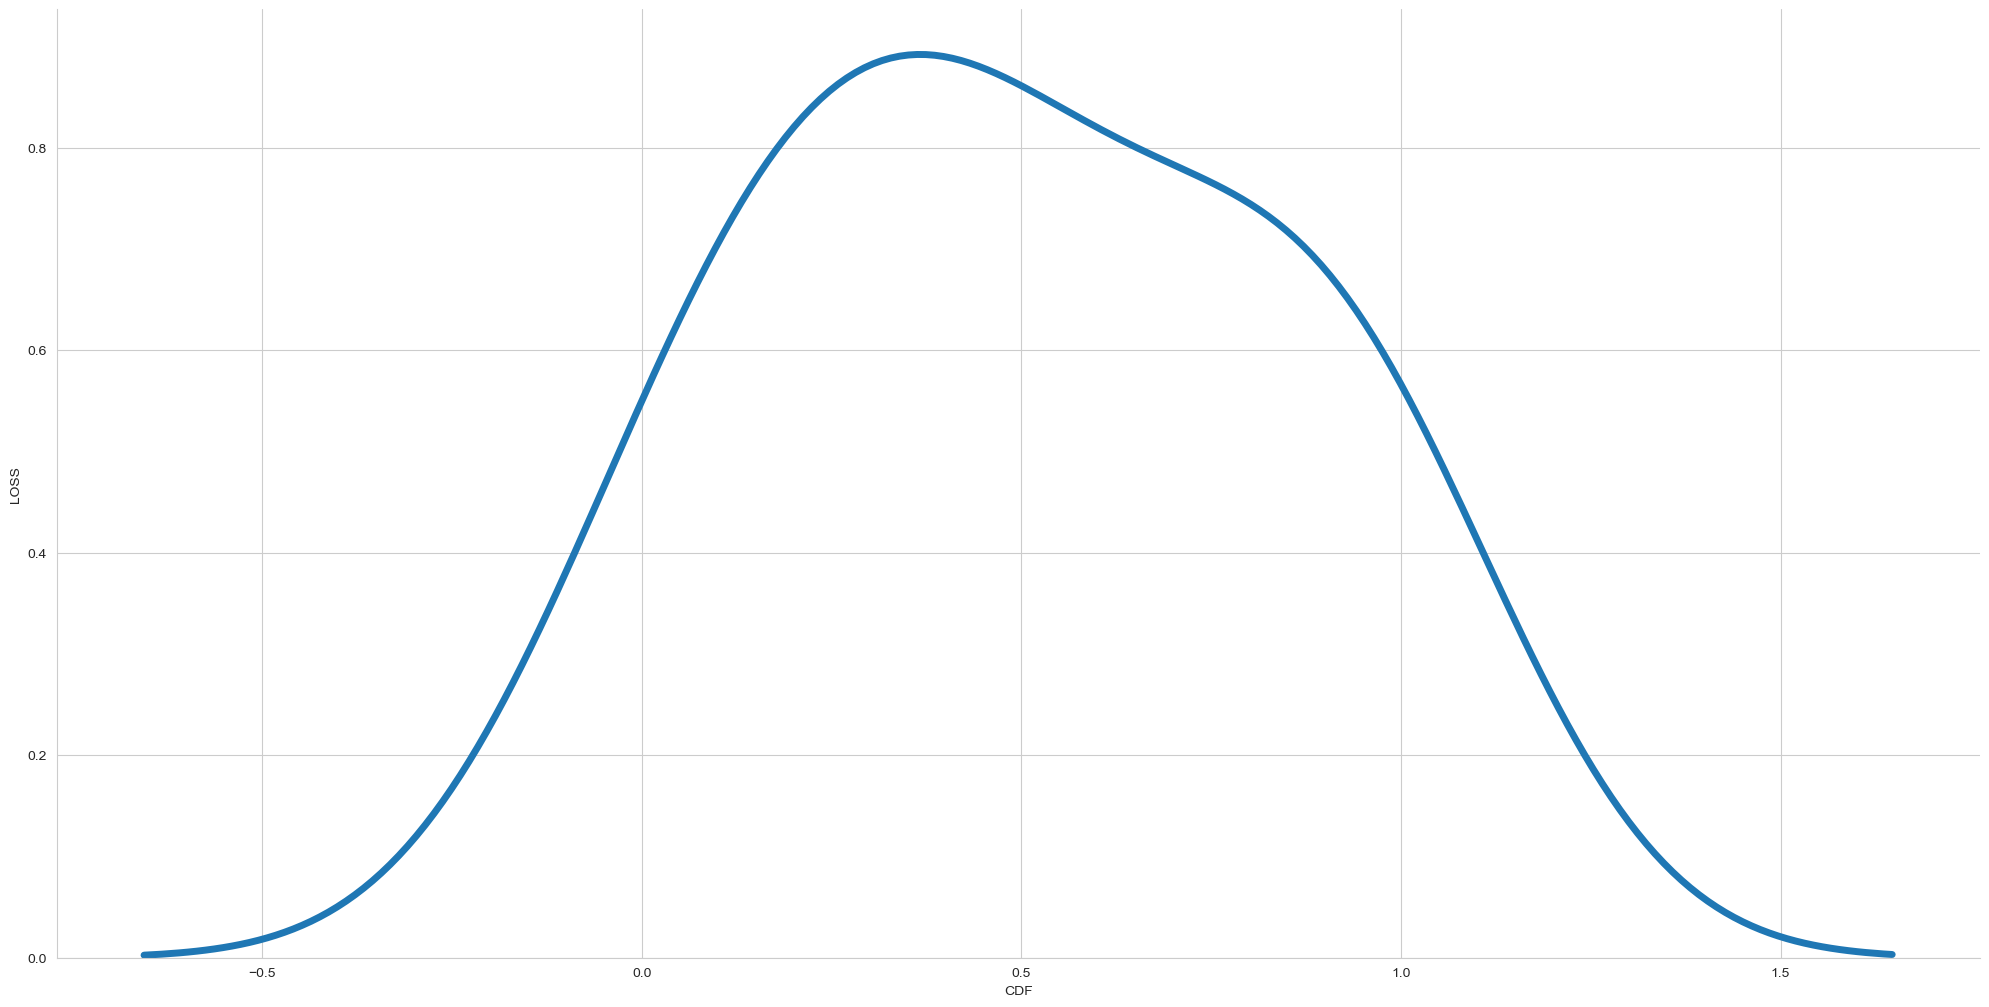

client_ 1  loss:  [0.60810548 0.49124789 0.42425817 0.38594407 0.36823279 0.35871762
 0.35395196 0.34909132 0.34512201 0.34348699] freq:  [ 38  72  80 100 154 175 210 265 301 304] acc [0.6895178  0.80177778 0.82569444 0.83469224 0.83653253 0.83756828
 0.83787876 0.83998203 0.84094632 0.84125489]


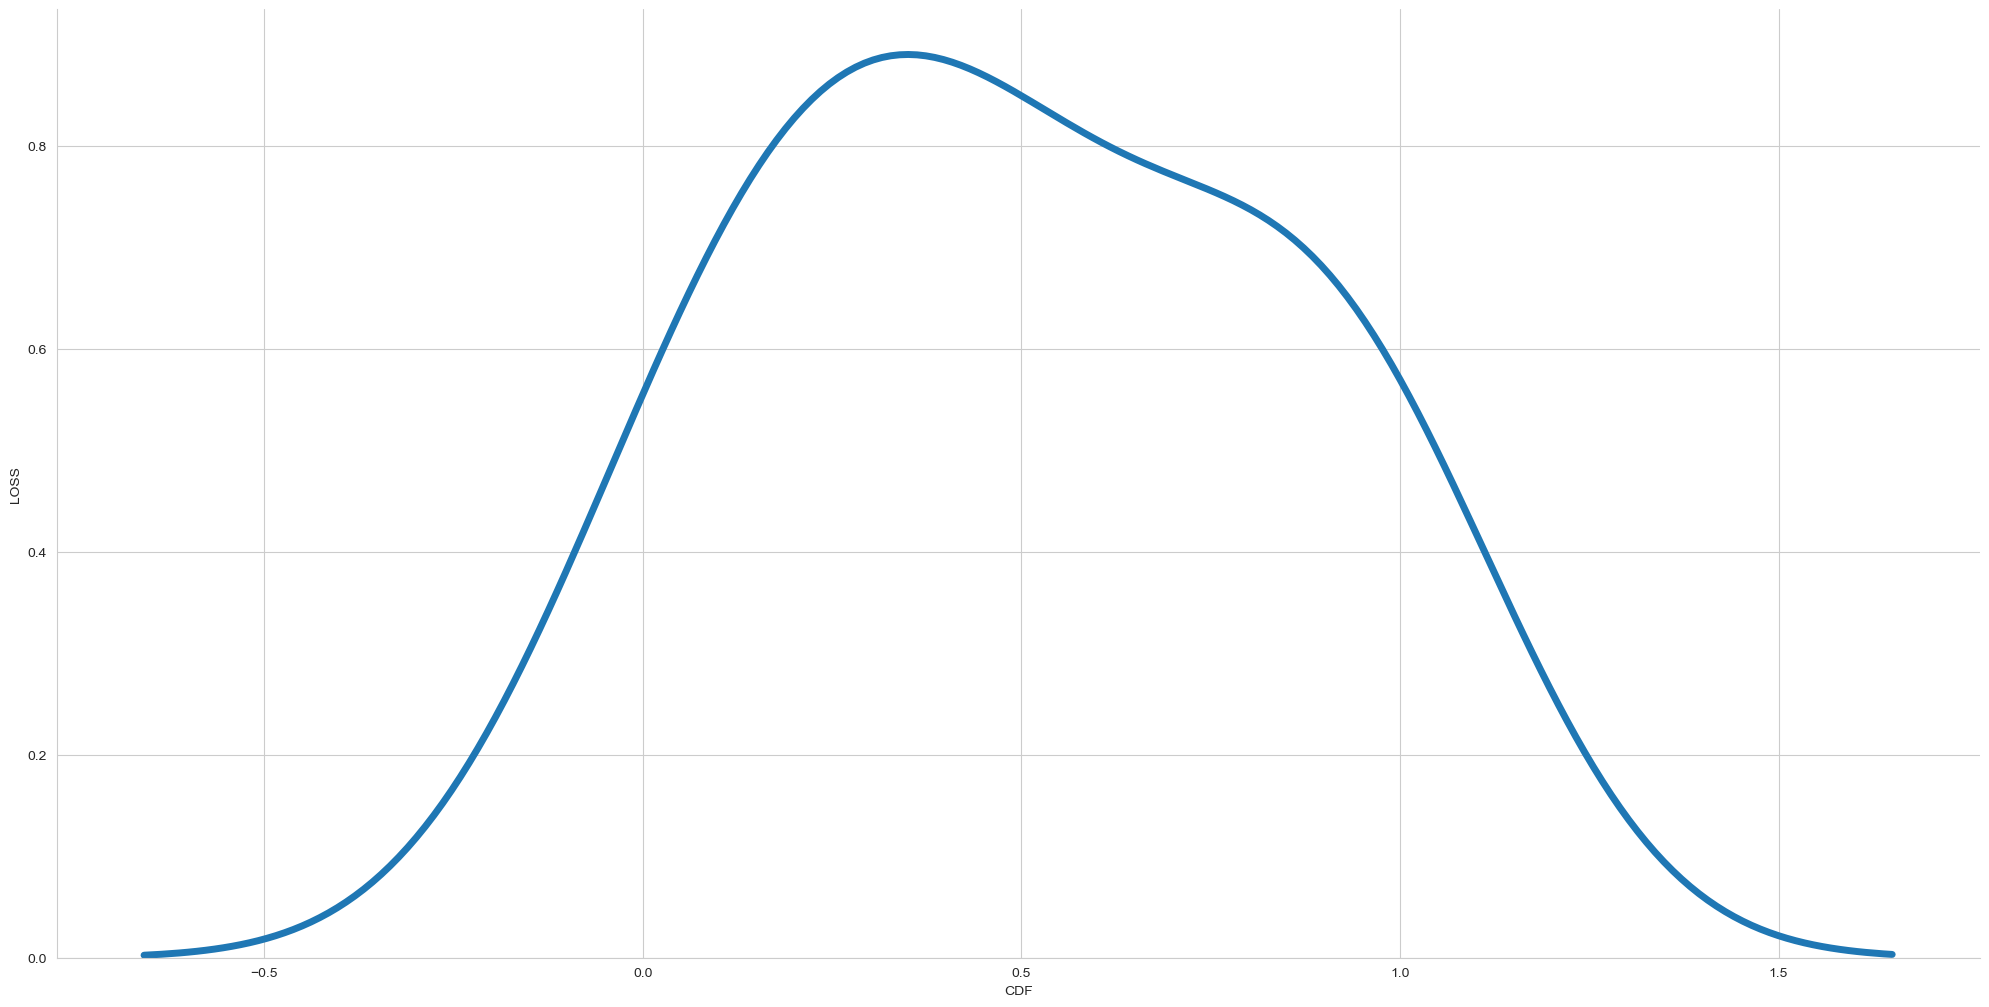

client_ 2  loss:  [0.62629861 0.5121786  0.42389324 0.38565096 0.36983481 0.3597762
 0.35359699 0.35081801 0.35046026 0.34585956] freq:  [ 26  28  61 119 128 167 202 222 248 308] acc [0.64890963 0.78917378 0.81968504 0.83105296 0.83345747 0.83466476
 0.83621299 0.83674204 0.83647132 0.83981413]


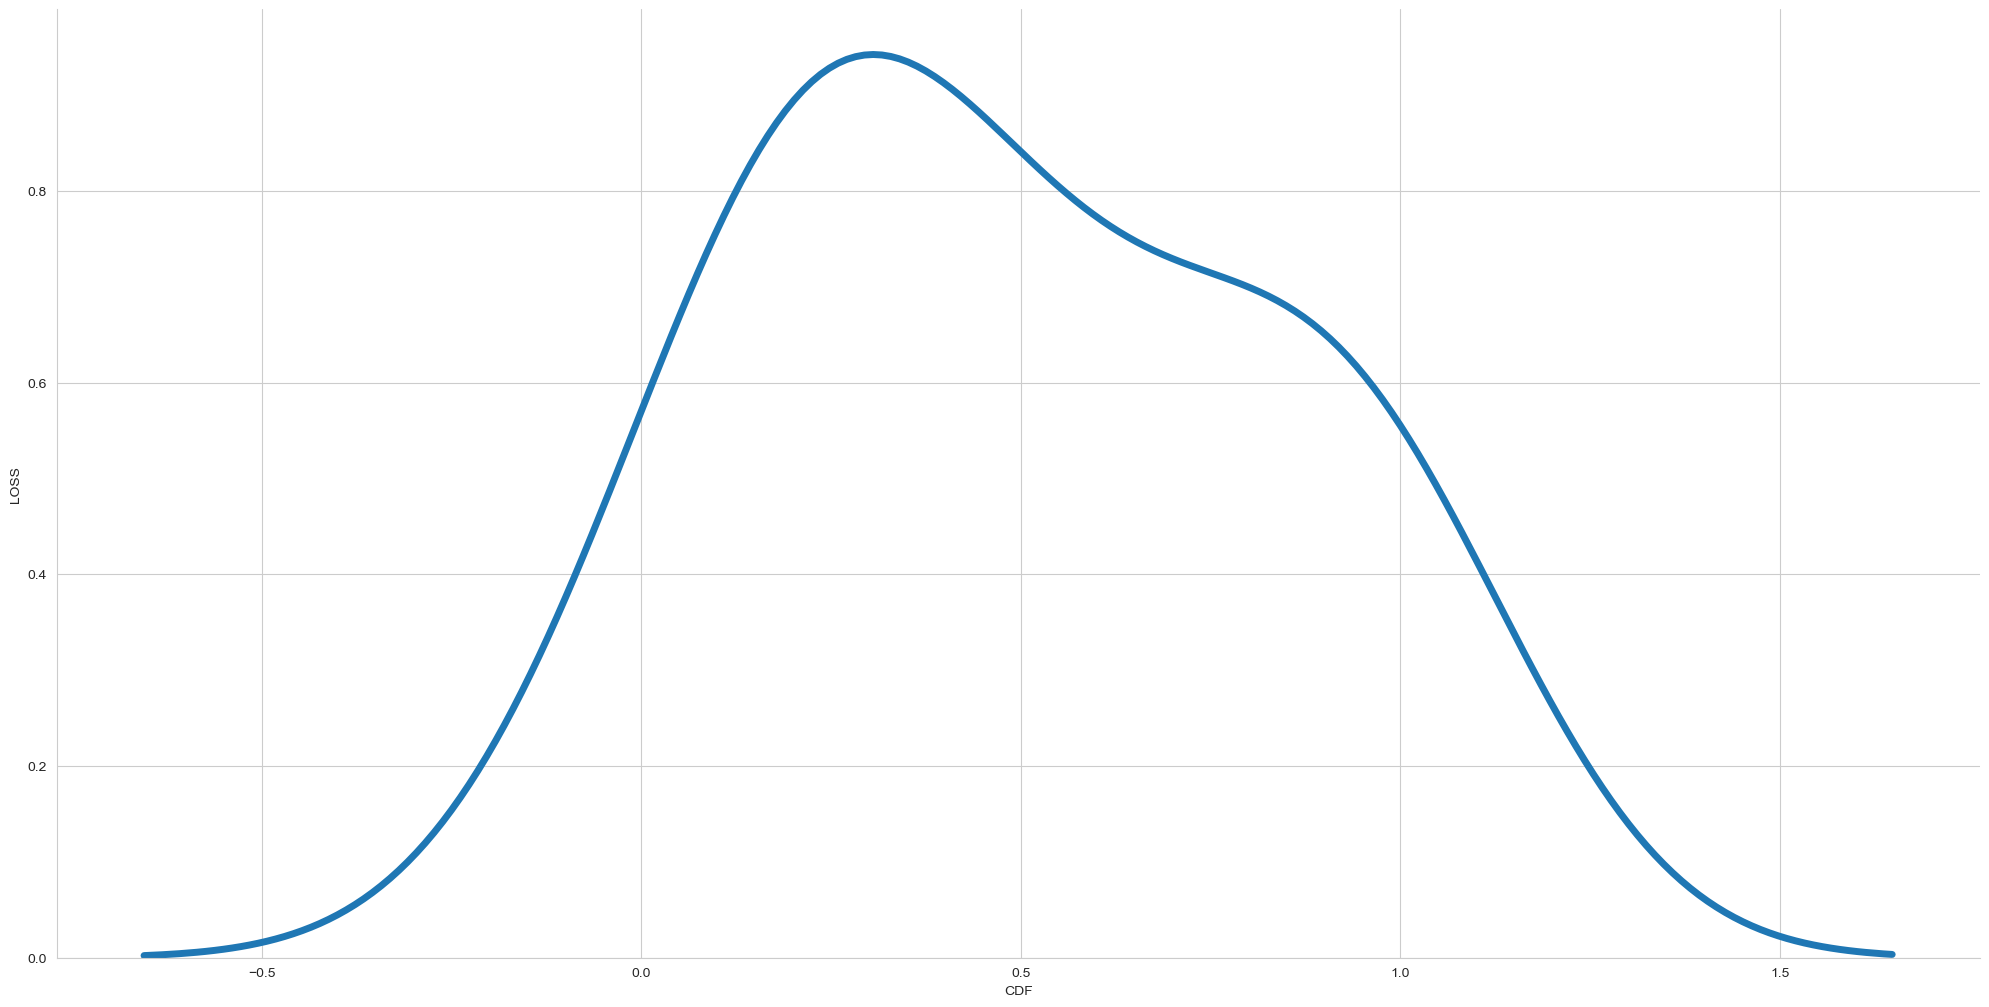

client_ 3  loss:  [0.5920248  0.47583362 0.42313868 0.3866969  0.37091368 0.36190581
 0.35488188 0.35127825 0.34916413 0.34639987] freq:  [ 49 102 104 119 124 138 185 201 215 265] acc [0.70891088 0.80850899 0.8235566  0.83092368 0.83423078 0.83580887
 0.83733851 0.83866507 0.83899999 0.83986813]


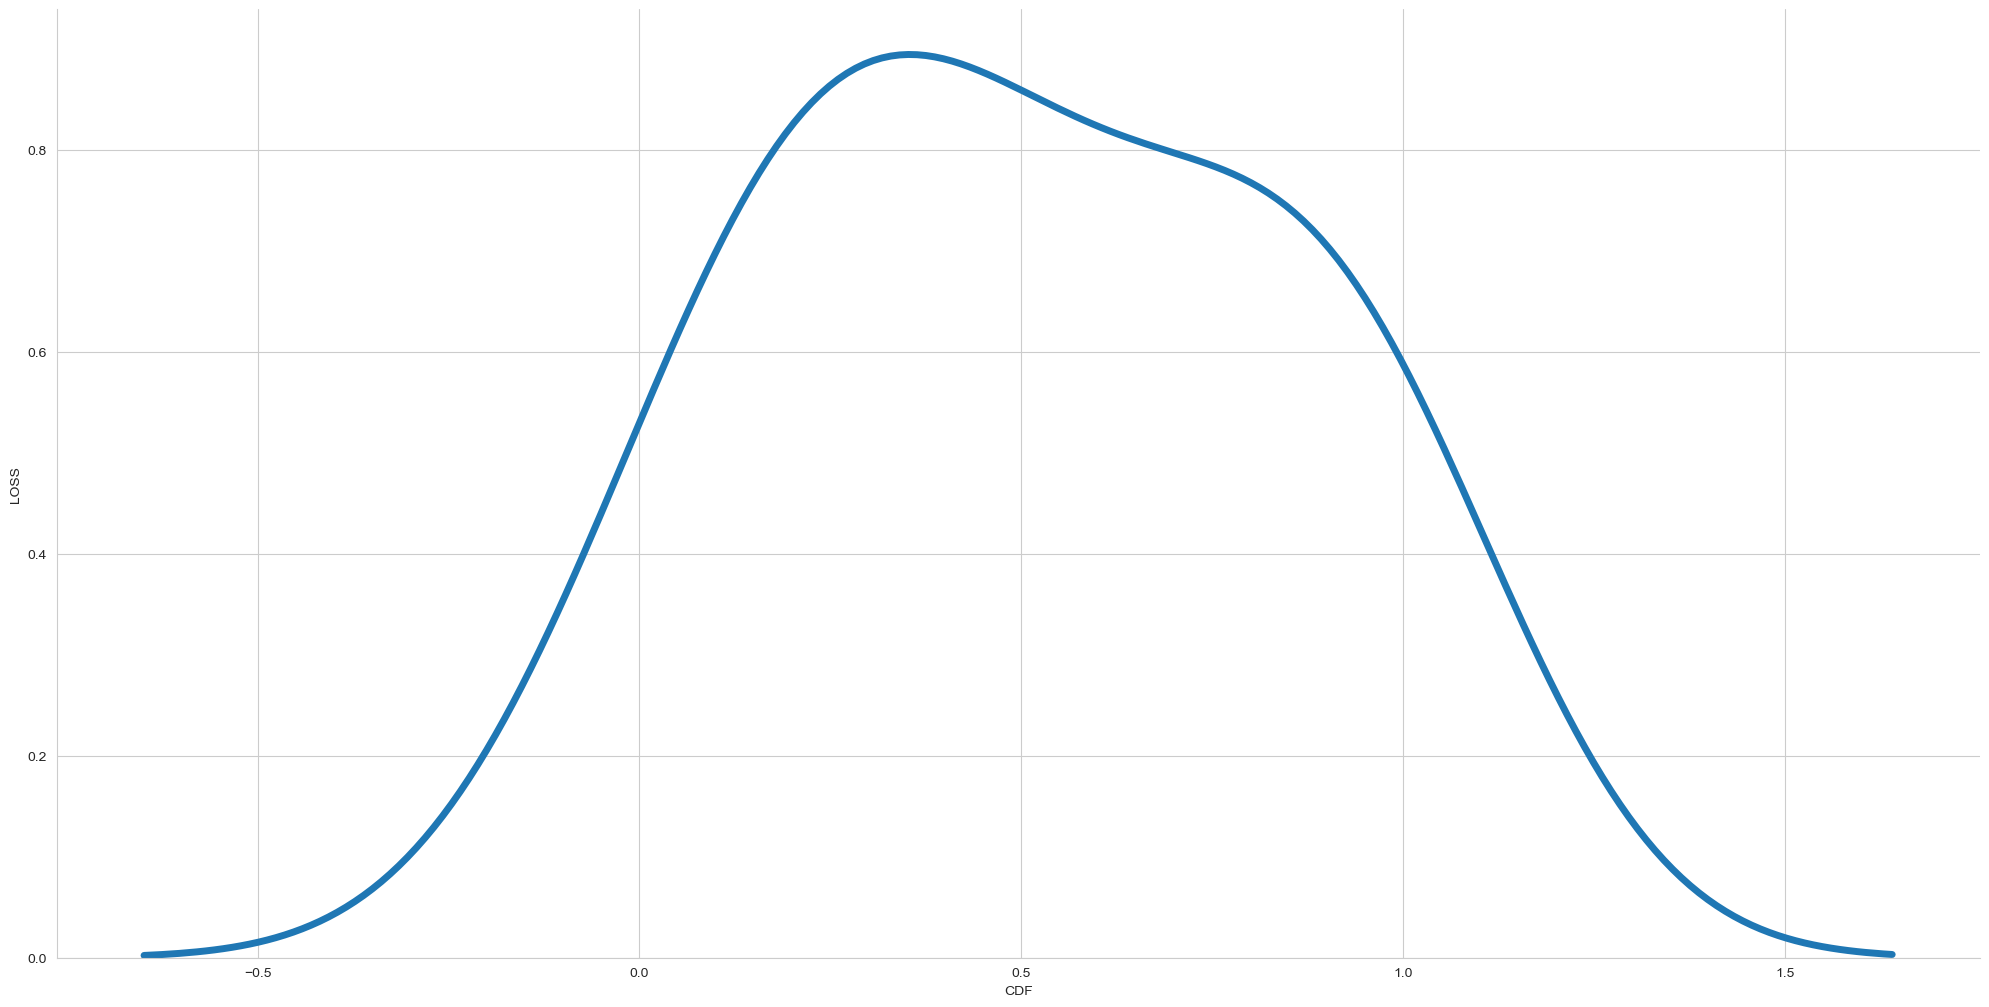

client_ 4  loss:  [0.65826589 0.5169788  0.42765966 0.38794741 0.36735302 0.35774747
 0.35061172 0.34742814 0.34490946 0.34517193] freq:  [ 11  26  53  78 123 172 209 224 249 315] acc [0.6068182  0.78535825 0.82666665 0.83210254 0.83792883 0.84053552
 0.84220952 0.84236926 0.84271133 0.84184933]


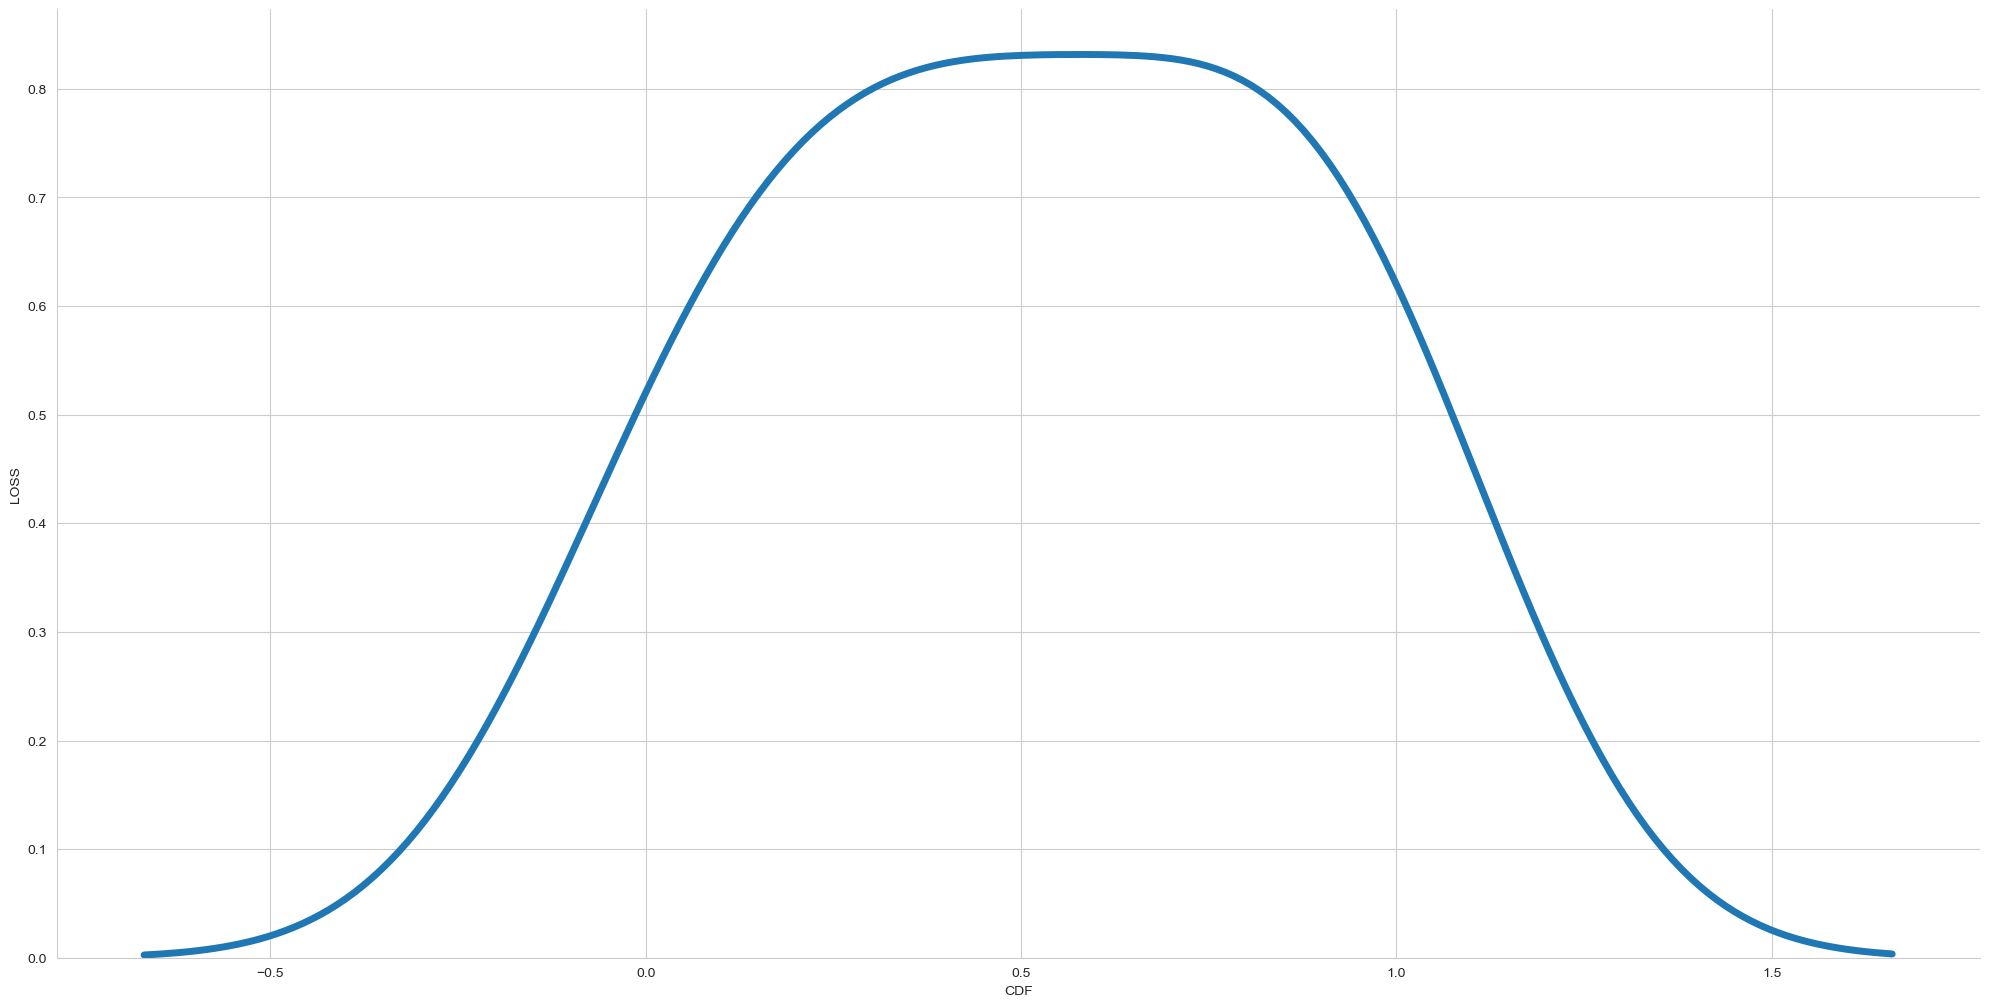

client_ 5  loss:  [0.61959428 0.48596308 0.40170121 0.37713358 0.3615804  0.35094073
 0.34597063 0.34304726 0.34170884 0.34019074] freq:  [ 31  74 155 190 254 301 345 408 456 501] acc [0.66692913 0.80526882 0.82871795 0.83496648 0.83968699 0.84224683
 0.84266943 0.84290451 0.84317309 0.84325564]


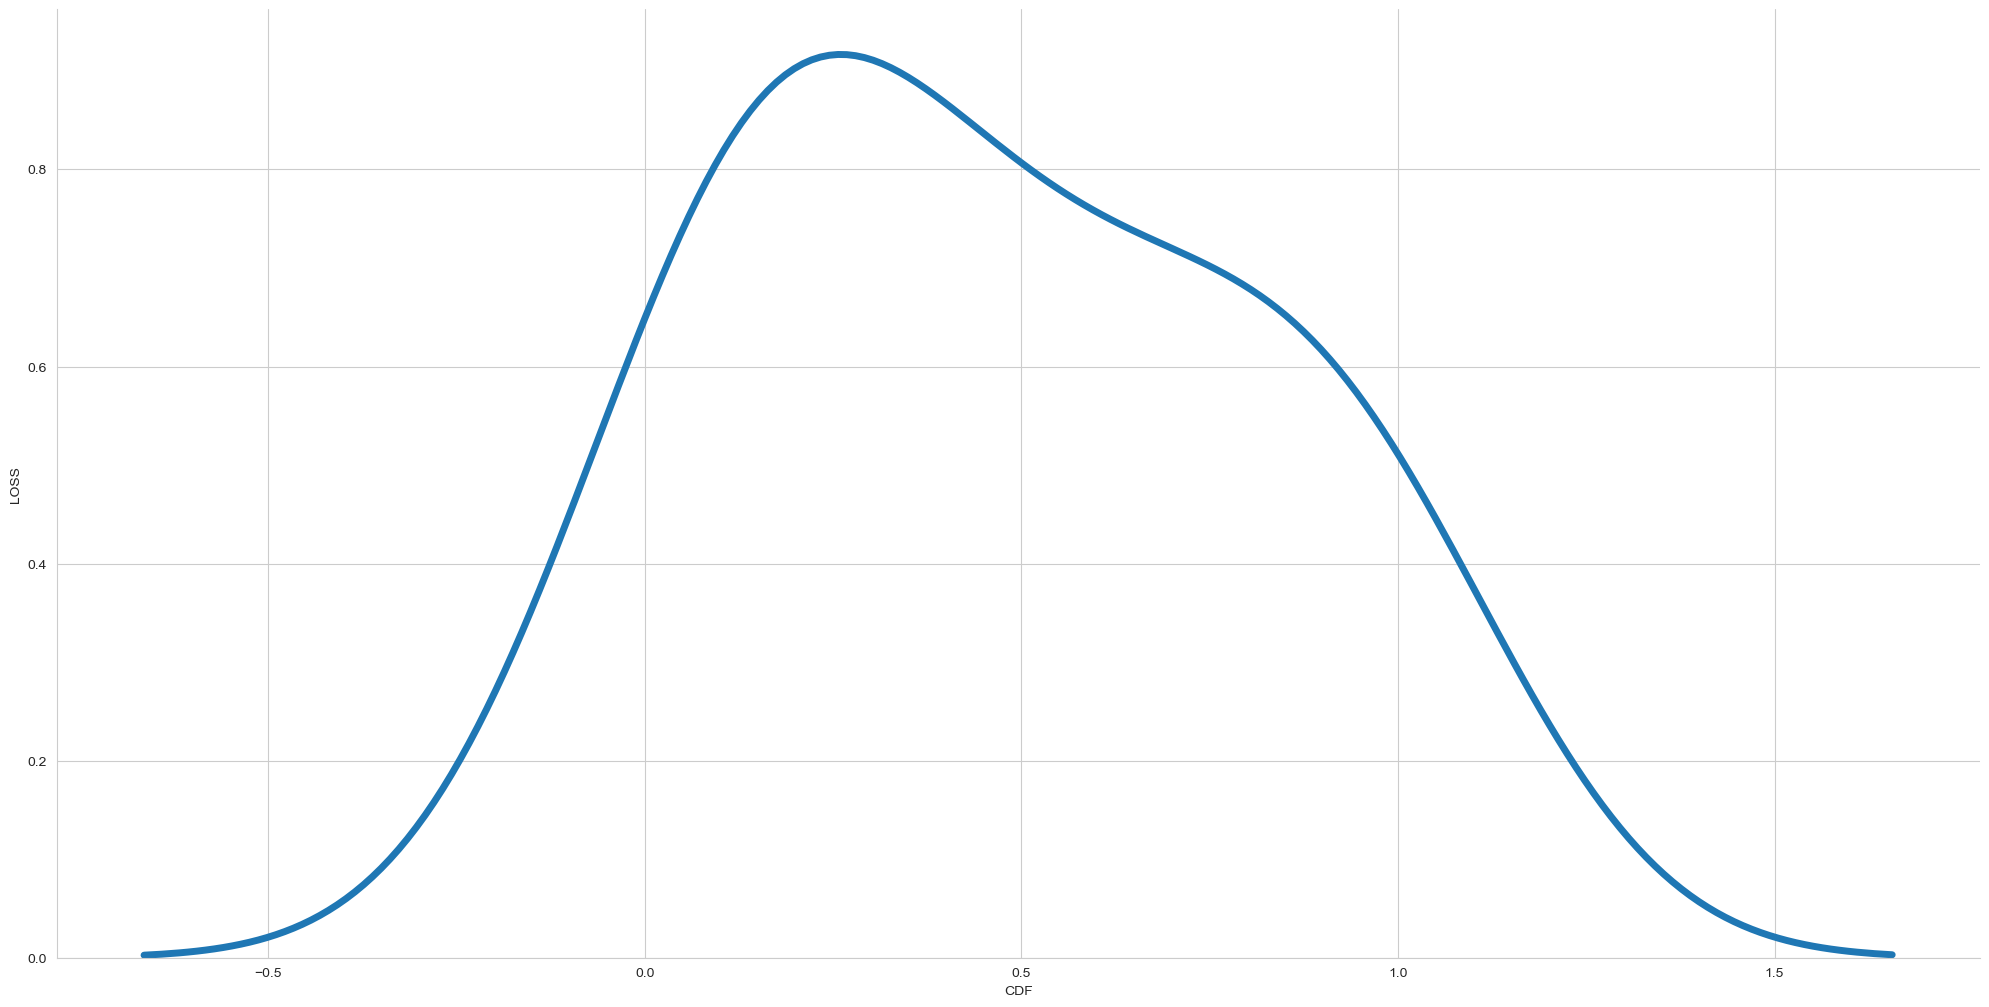

client_ 6  loss:  [0.63035935 0.5015859  0.4151603  0.3802737  0.36296323 0.35536006
 0.35027575 0.3468076  0.34330562 0.34104306] freq:  [ 23  48  91 135 164 209 225 248 287 306] acc [0.6536842  0.79149997 0.83095866 0.83722717 0.84047621 0.84233409
 0.84359521 0.84452999 0.84544194 0.84531045]


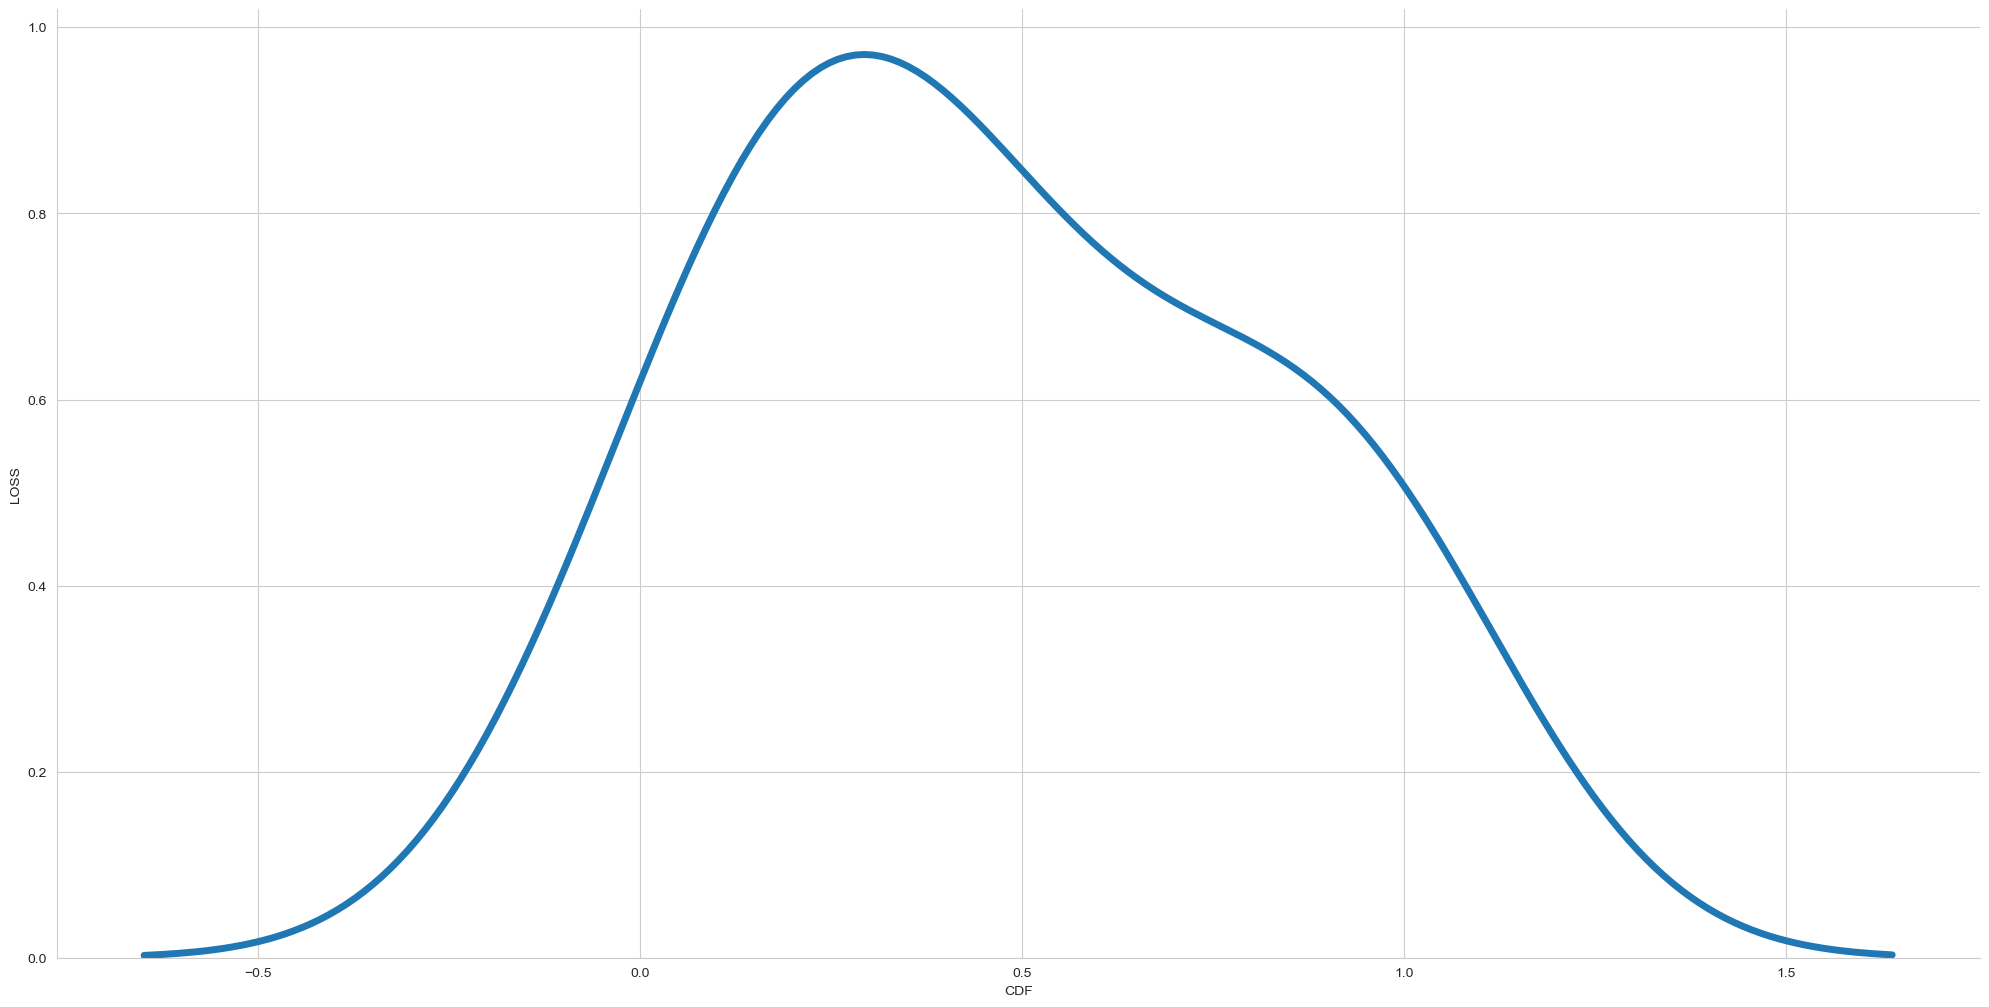

client_ 7  loss:  [0.67178184 0.51838964 0.42784214 0.38460797 0.36651531 0.358017
 0.35256788 0.34676394 0.34442586 0.34205738] freq:  [  2  27  40  91 124 172 187 232 261 263] acc [0.60666668 0.79030305 0.82404041 0.83298153 0.83513516 0.8371706
 0.83821654 0.83956194 0.84028029 0.84116048]


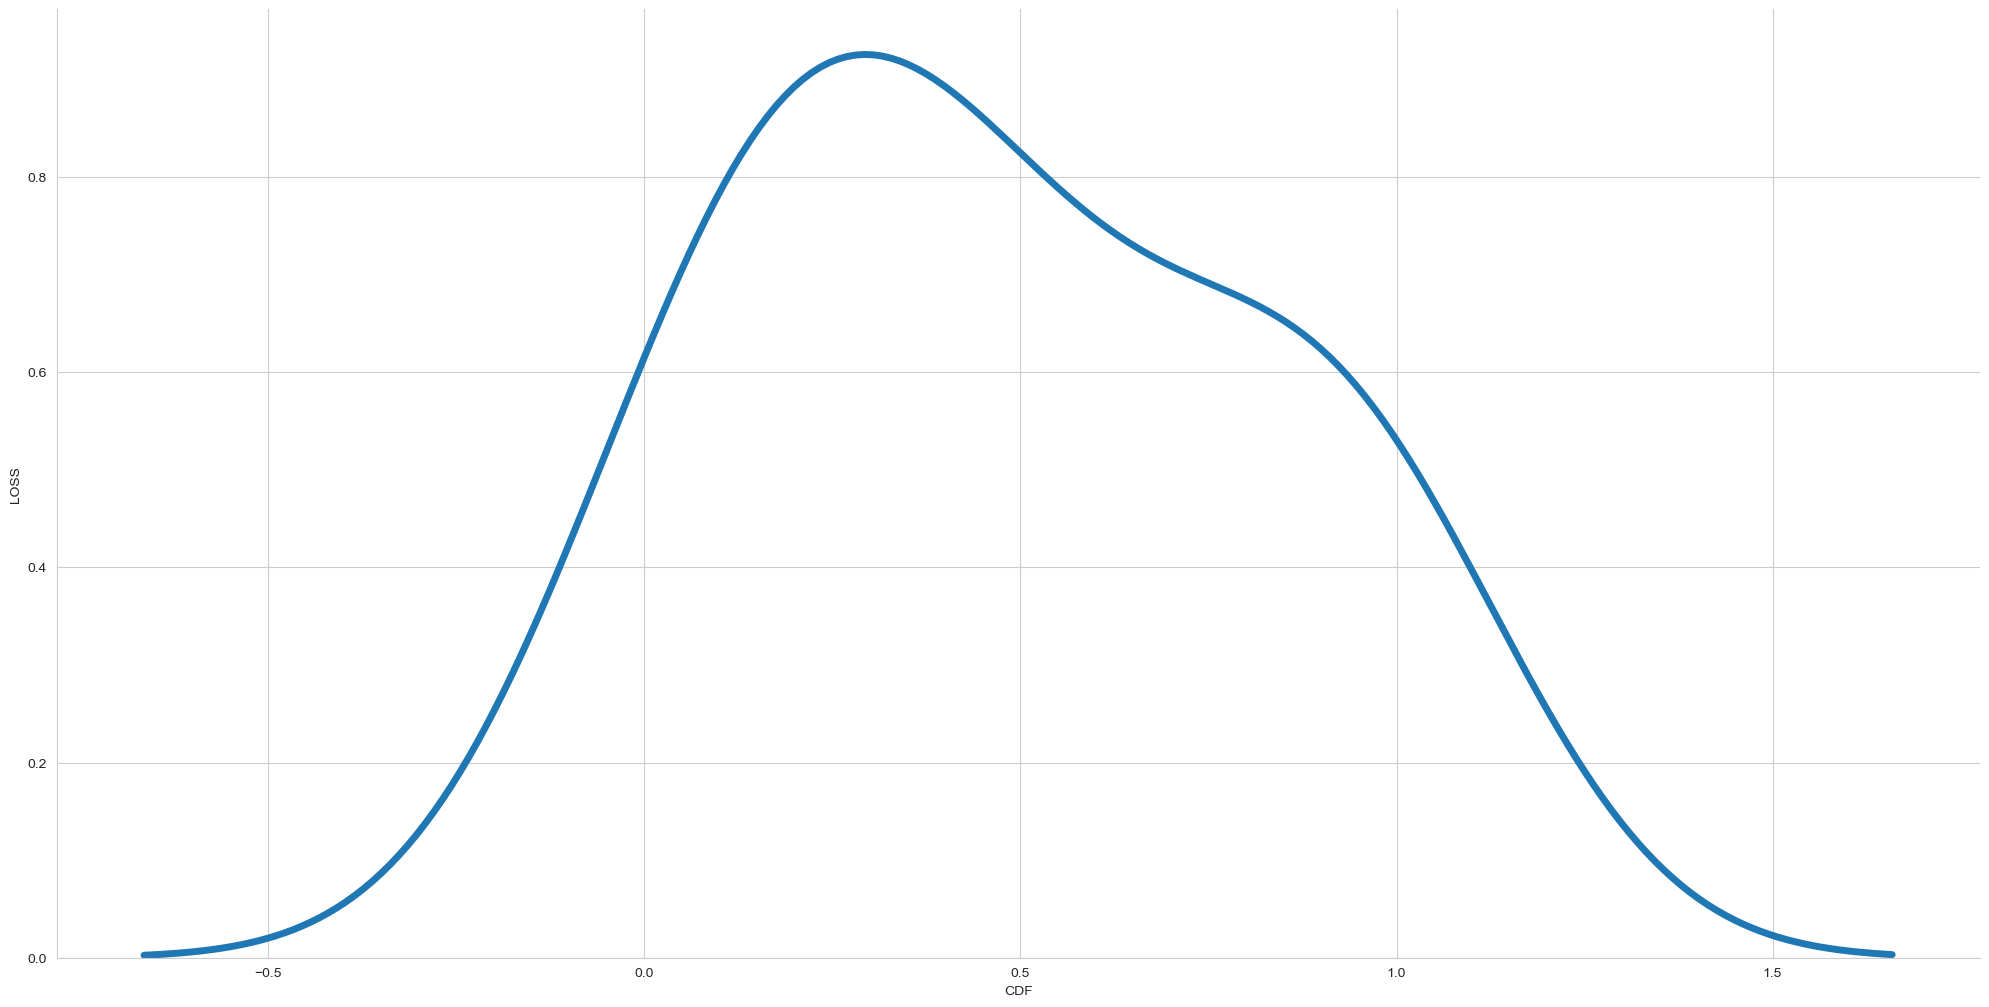

client_ 8  loss:  [0.58725697 0.49155888 0.41370627 0.38253722 0.36716944 0.35897282
 0.35035193 0.34639585 0.34351107 0.34077337] freq:  [ 51  64 112 133 145 158 187 200 215 222] acc [0.71806854 0.80588973 0.82985073 0.83530468 0.83838552 0.83816719
 0.84089172 0.84224343 0.84337038 0.84474343]


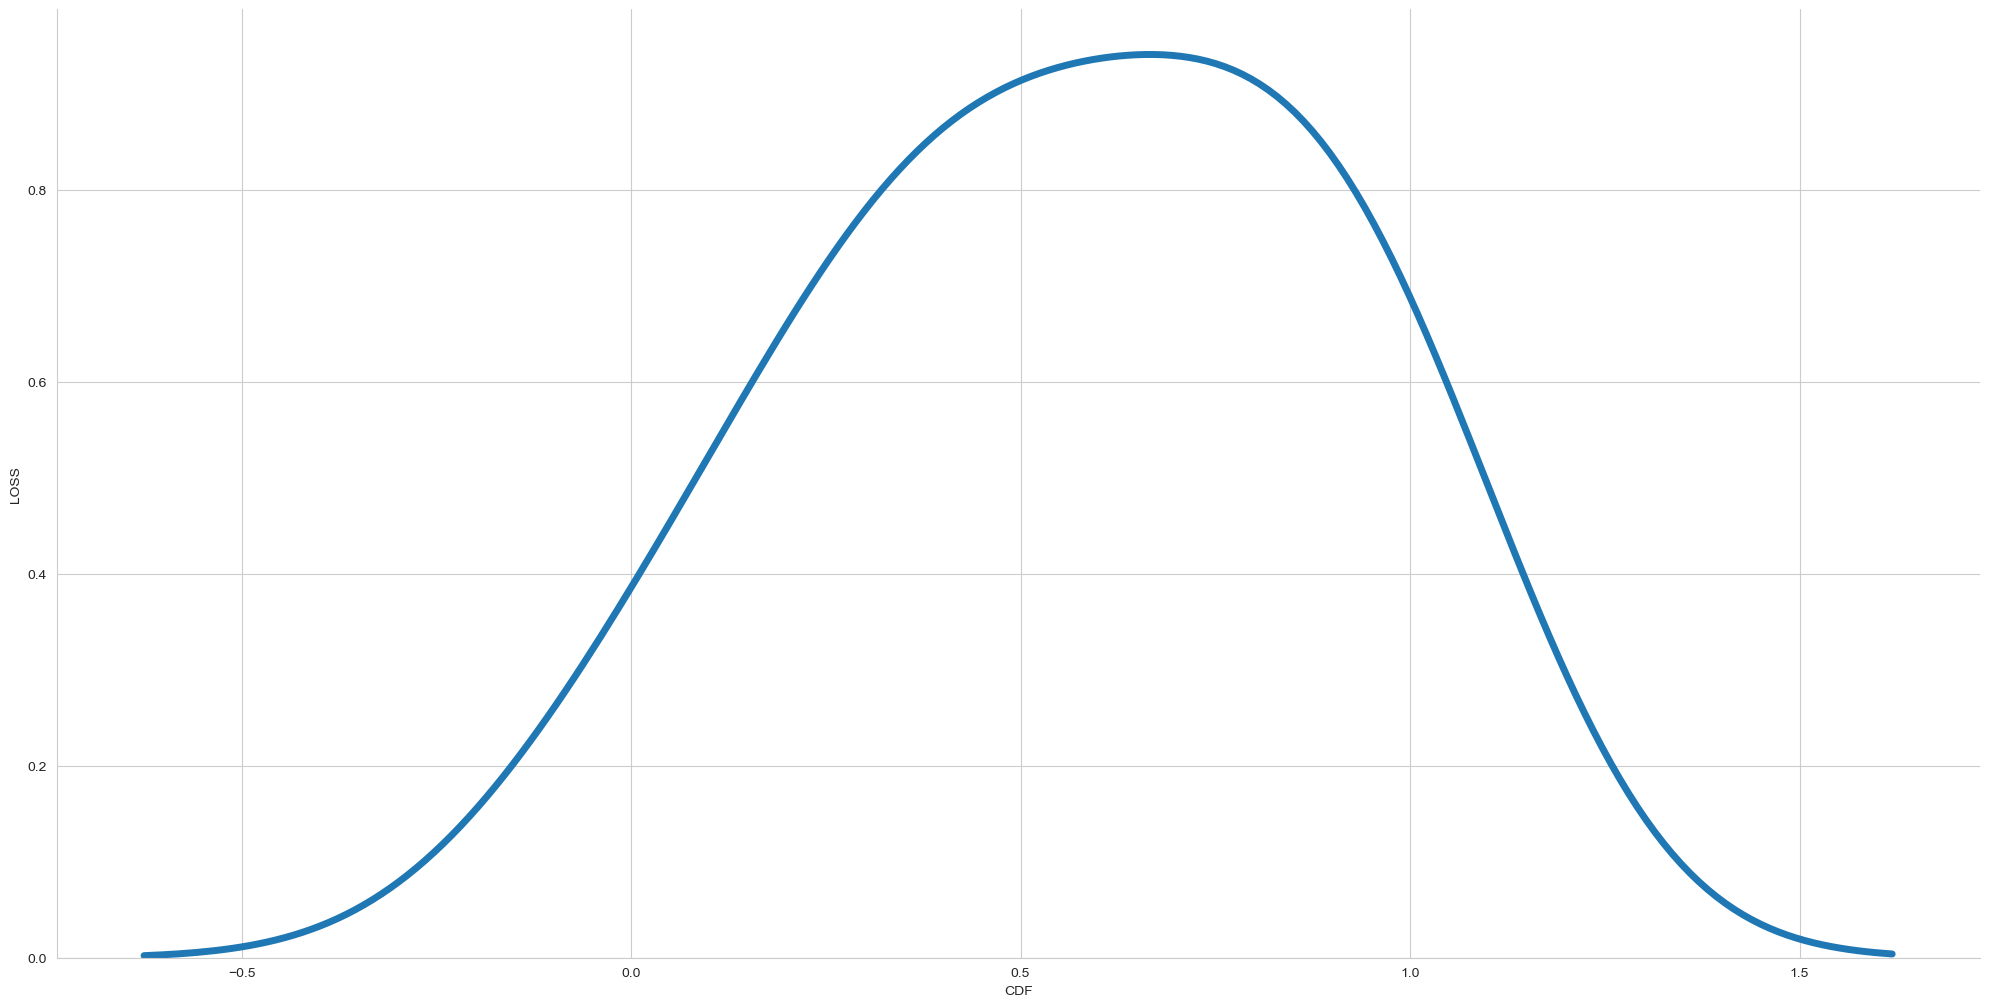

client_ 9  loss:  [0.58318889 0.45914096 0.40776464 0.37675032 0.36124367 0.35230872
 0.34864539 0.3455101  0.34278136 0.34076509] freq:  [ 50 120 150 182 203 236 270 287 310 311] acc [0.72603172 0.8139165  0.82998937 0.8375383  0.84057969 0.84284753
 0.84299177 0.84381586 0.84391373 0.84510106]


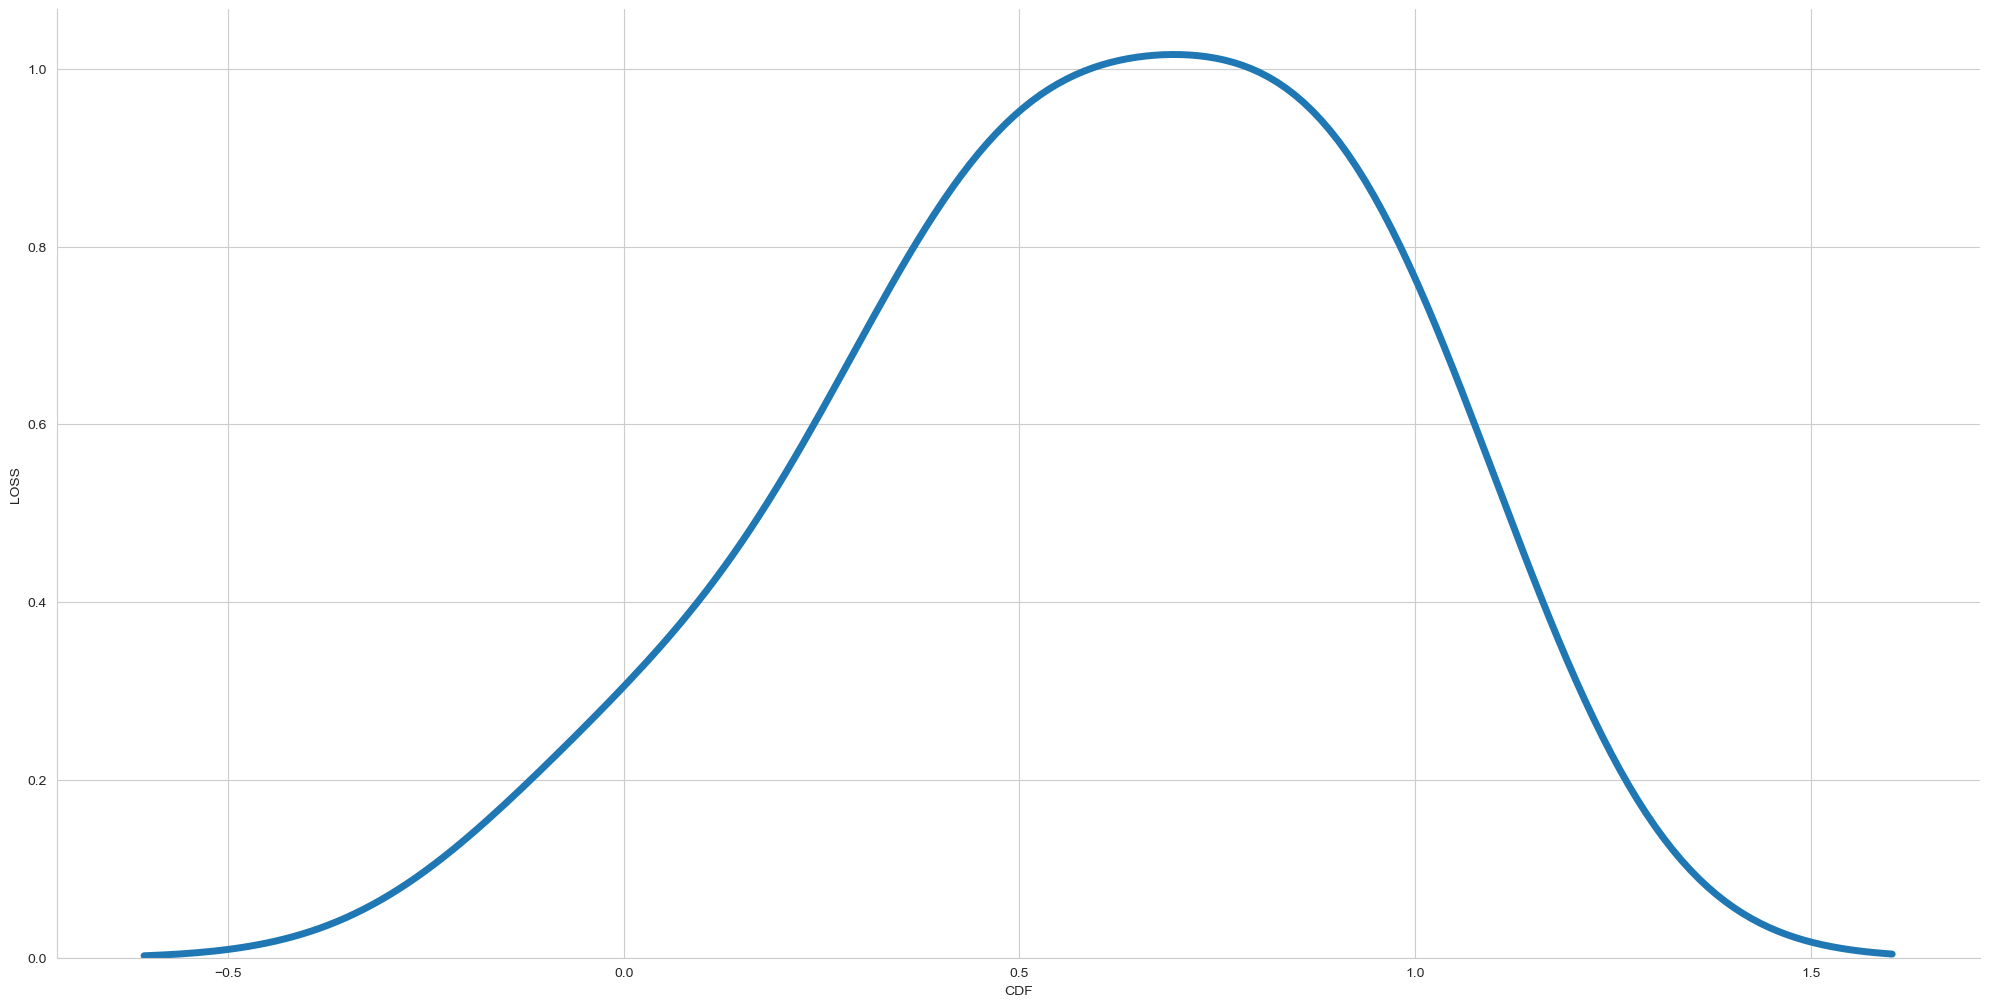

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 

pdfs = []
for i in list(client_accuracy.keys()):
    print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i], "acc", client_accuracy[i])
    
#     norm
#     mean, std = stats.norm.fit(client_loss[i])
#     pdf =  stats.norm.pdf(client_loss[i], mean, std)

#     df_mean = np.mean(client_frequency[i])
#     df_std = np.std(client_frequency[i])
#     pdf = stats.norm.pdf(client_frequency[i], df_mean, df_std)
    
#     lognorm
#     shape, loc, scale = stats.lognorm.fit(client_loss[i])
#     pdf = stats.lognorm.pdf(client_loss[i], shape, loc, scale)

#     beta
#     beta_params = stats.beta.fit(client_loss[i])
#     pdf = stats.beta.pdf(client_loss[i], beta_params[0], beta_params[1], beta_params[2], beta_params[3])

#     burr
#     burr_params = stats.burr.fit(client_loss[i])
#     pdf = stats.burr.pdf(client_loss[i], burr_params[0], burr_params[1], burr_params[2], burr_params[3])

    
#  gamma
    shape, loc, scale = stats.gamma.fit(client_loss[i])
    pdf = stats.gamma.cdf(client_loss[i], shape, loc=loc, scale=scale)
    
    pdfs.append(pdf)
    sns.set_style("whitegrid")

    ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
                linewidth = 5 )
    plt.ylabel("LOSS")
#     plt.xlabel("Loss")
    plt.xlabel("CDF")
    
    plt.show()

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 

for i in list(client_accuracy.keys()):
    print("client_",i, "\nloss: ", client_loss[i],"\nfreq: ", client_frequency[i], "\nacc", client_accuracy[i])

client_ 0 
loss:  [0.61086375 0.48895925 0.42192078 0.38538462 0.36777058 0.35811067
 0.35217971 0.34762534 0.34223405 0.34042257] 
freq:  [ 34  63  89  99 135 136 155 198 253 310] 
acc [0.68465227 0.80593437 0.82598567 0.83244336 0.83575219 0.83884007
 0.84030771 0.84148592 0.84315759 0.84329736]
client_ 1 
loss:  [0.60810548 0.49124789 0.42425817 0.38594407 0.36823279 0.35871762
 0.35395196 0.34909132 0.34512201 0.34348699] 
freq:  [ 38  72  80 100 154 175 210 265 301 304] 
acc [0.6895178  0.80177778 0.82569444 0.83469224 0.83653253 0.83756828
 0.83787876 0.83998203 0.84094632 0.84125489]
client_ 2 
loss:  [0.62629861 0.5121786  0.42389324 0.38565096 0.36983481 0.3597762
 0.35359699 0.35081801 0.35046026 0.34585956] 
freq:  [ 26  28  61 119 128 167 202 222 248 308] 
acc [0.64890963 0.78917378 0.81968504 0.83105296 0.83345747 0.83466476
 0.83621299 0.83674204 0.83647132 0.83981413]
client_ 3 
loss:  [0.5920248  0.47583362 0.42313868 0.3866969  0.37091368 0.36190581
 0.35488188 0.35127

In [35]:
print("_GAMMA_")

cdfs_loss_gamma = []
cdfs_acc_gamma = []
cdfs_freq_gamma = []
for i in list(client_accuracy.keys()):
#     print("client_",i, "\nloss: ", client_loss[i],"\nfreq: ", client_frequency[i], "\nacc", client_accuracy[i])

    shape, loc, scale = stats.gamma.fit(client_loss[i])
    cdf_loss_gamma =  stats.gamma.cdf(client_loss[i], shape, loc, scale)
    cdfs_loss_gamma.append(cdf_loss_gamma)

    shape, loc, scale= stats.gamma.fit(client_accuracy[i])
    cdf_acc_gamma = stats.gamma.cdf(client_accuracy[i],shape, loc, scale)
    cdfs_acc_gamma.append(cdf_acc_gamma)

    shape, loc, scale  = stats.gamma.fit(client_frequency[i])
    cdf_freq_gamma = stats.gamma.cdf(client_frequency[i],shape, loc, scale )
    cdfs_freq_gamma.append(cdf_freq_gamma)


print("ACCURACY")
for i in range(len(cdfs_acc_gamma)):
    for j in range(i+1,len(cdfs_acc_gamma)):
        print(i," and ", j , stats.wasserstein_distance(cdfs_acc_gamma[i], cdfs_acc_gamma[j]))


shape, loc, scale = stats.gamma.fit(global_acc_list)
cdf_global_acc_gamma =  stats.gamma.cdf(global_acc_list, shape, loc, scale)

for i in range(len(cdfs_acc_gamma)):
    print(i," and global: " , stats.wasserstein_distance(cdfs_acc_gamma[i], cdf_global_acc_gamma))

print("LOSS")
for i in range(len(cdfs_loss_gamma)):
    for j in range(i+1,len(cdfs_loss_gamma)):
        print(i," and ", j , stats.wasserstein_distance(cdfs_loss_gamma[i], cdfs_loss_gamma[j]))


shape, loc, scale = stats.gamma.fit(global_loss_list)
cdf_global_loss_gamma =  stats.gamma.cdf(global_loss_list, shape, loc, scale)

for i in range(len(cdfs_loss_gamma)):
    print(i," and global: " , stats.wasserstein_distance(cdfs_loss_gamma[i], cdf_global_loss_gamma))

print("FREQUENCY")
for i in range(len(cdfs_freq_gamma)):
    for j in range(i+1,len(cdfs_freq_gamma)):
        print(i," and ", j , stats.wasserstein_distance(cdfs_freq_gamma[i], cdfs_freq_gamma[j]))


shape, loc, scale = stats.gamma.fit(global_freq_list)
cdf_global_freq_gamma =  stats.gamma.cdf(global_freq_list,shape, loc, scale)

for i in range(len(cdfs_freq_gamma)):
    print(i," and global: " , stats.wasserstein_distance(cdfs_freq_gamma[i], cdf_global_freq_gamma))

_GAMMA_
ACCURACY
0  and  1 0.16922599600770416
0  and  2 0.015600465325442597
0  and  3 0.3326675944011425
0  and  4 0.13311156524333806
0  and  5 0.002088637781454481
0  and  6 0.0029715160910101387
0  and  7 0.08490192281680213
0  and  8 0.377265077145193
0  and  9 0.05880820171523992
1  and  2 0.15362553068226154
1  and  3 0.1634415983934384
1  and  4 0.03611443077190012
1  and  5 0.16763187651343472
1  and  6 0.16917606708037777
1  and  7 0.08432407319486346
1  and  8 0.2080390811374888
1  and  9 0.22803419771725916
2  and  3 0.31706712907569995
2  and  4 0.11751109991968871
2  and  5 0.01400634583117321
2  and  6 0.015550536398116257
2  and  7 0.0693014574931528
2  and  8 0.3616646118197504
2  and  9 0.07440866703888924
3  and  4 0.19955602916533852
3  and  5 0.3310734749068731
3  and  6 0.33261766547381616
3  and  7 0.24776567158830184
3  and  8 0.04463201943717401
3  and  9 0.39147579611069744
4  and  5 0.1315174457439552
4  and  6 0.13306163630933018
4  and  7 0.048209642426535

In [36]:

# for i in range(len(pdfs_loss_gamma)):
#     print(i," and global: " , stats.wasserstein_distance(pdfs_loss_gamma[i], pdf_global_loss_gamma))
#     M = ot.dist(pdfs_loss_gamma[i], pdf_global_loss_gamma, metric='euclidean')
#     W = ot.emd2(pdfs_loss_gamma[i], pdf_global_loss_gamma, M)
#     print("actual ", W)

In [38]:
print("_NORM_")

pdfs_loss_norm = []
pdfs_acc_norm = []
pdfs_freq_norm = []
for i in list(client_accuracy.keys()):
#     print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i], "acc", client_accuracy[i])
    
    mean, std = stats.norm.fit(client_loss[i])
    pdf_loss_norm =  stats.norm.pdf(client_loss[i], mean, std)
    pdfs_loss_norm.append(pdf_loss_norm)

    mean, std = stats.norm.fit(client_accuracy[i])
    pdf_acc_norm = stats.norm.pdf(client_accuracy[i],mean, std )
    pdfs_acc_norm.append(pdf_acc_norm)
    
    mean, std  = stats.norm.fit(client_frequency[i])
    pdf_freq_norm = stats.norm.pdf(client_frequency[i], mean, std )
    pdfs_freq_norm.append(pdf_freq_norm)
    
    
print("ACCURACY")
for i in range(len(pdfs_acc_norm)):
    for j in range(i+1,len(pdfs_acc_norm)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc_norm[i], pdfs_acc_norm[j]))
        
        
mean, std = stats.norm.fit(global_acc_list)
pdf_global_acc_norm =  stats.norm.pdf(global_acc_list, mean, std)

for i in range(len(pdfs_acc_norm)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc_norm[i], pdf_global_acc_norm))
    
print("LOSS")
for i in range(len(pdfs_loss_norm)):
    for j in range(i+1,len(pdfs_loss_norm)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss_norm[i], pdfs_loss_norm[j]))
        
        
mean, std = stats.norm.fit(global_loss_list)
pdf_global_loss_norm =  stats.norm.pdf(global_loss_list, mean, std)

for i in range(len(pdfs_loss_norm)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss_norm[i], pdf_global_loss_norm))
    
print("FREQUENCY")
for i in range(len(pdfs_freq_norm)):
    for j in range(i+1,len(pdfs_freq_norm)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_freq_norm[i], pdfs_freq_norm[j]))
        
        
mean, std = stats.norm.fit(global_freq_list)
pdf_global_freq_norm =  stats.norm.pdf(global_freq_list, mean, std)

for i in range(len(pdfs_freq_norm)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_freq_norm[i], pdf_global_freq_norm))


_NORM_
ACCURACY
0  and  1 0.2245756712154016
0  and  2 1.2761413388197487
0  and  3 1.5135437623323724
0  and  4 2.4396181174037053
0  and  5 0.7807682953335693
0  and  6 1.4064985411017061
0  and  7 2.3515025158024367
0  and  8 1.6842658701550506
0  and  9 2.2852486321064385
1  and  2 1.5007170100351503
1  and  3 1.288968091116971
1  and  4 2.664193788619106
1  and  5 1.0053439665489707
1  and  6 1.631074212317108
1  and  7 2.576078187017838
1  and  8 1.4596901989396491
1  and  9 2.060672960891037
2  and  3 2.7896851011521213
2  and  4 1.163476778583956
2  and  5 0.49562179423957153
2  and  6 0.1308401722626124
2  and  7 1.0753611769826872
2  and  8 2.9604072089747997
2  and  9 3.561389970926188
3  and  4 3.953161879736077
3  and  5 2.2943120576659415
3  and  6 2.920042303434079
3  and  7 3.865046278134809
3  and  8 0.17239334782569518
3  and  9 0.7717048697740664
4  and  5 1.6588498220701355
4  and  6 1.033119576301999
4  and  7 0.08881724428228423
4  and  8 4.123883987558755
4  and 

In [39]:
print("_LOGNORM_")

pdfs_loss = []
pdfs_acc = []
pdfs_freq = []
for i in list(client_accuracy.keys()):
#     print("client_",i, "\nloss: ", client_loss[i],"\nfreq: ", client_frequency[i], "\nacc", client_accuracy[i])

    shape, loc, scale = stats.lognorm.fit(client_loss[i])
    pdf_loss =  stats.lognorm.pdf(client_loss[i], shape, loc, scale)
    pdfs_loss.append(pdf_loss)

    shape, loc, scale= stats.lognorm.fit(client_accuracy[i])
    pdf_acc = stats.lognorm.pdf(client_accuracy[i],shape, loc, scale)
    pdfs_acc.append(pdf_acc)

    shape, loc, scale  = stats.lognorm.fit(client_frequency[i])
    pdf_freq = stats.lognorm.pdf(client_frequency[i],shape, loc, scale )
    pdfs_freq.append(pdf_freq)


print("ACCURACY")
for i in range(len(pdfs_acc)):
    for j in range(i+1,len(pdfs_acc)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc[i], pdfs_acc[j]))


shape, loc, scale = stats.lognorm.fit(global_acc_list)
pdf_global_acc =  stats.lognorm.pdf(global_acc_list, shape, loc, scale)

for i in range(len(pdfs_acc)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc[i], pdf_global_acc))

print("LOSS")
for i in range(len(pdfs_loss)):
    for j in range(i+1,len(pdfs_loss)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss[i], pdfs_loss[j]))


shape, loc, scale = stats.lognorm.fit(global_loss_list)
pdf_global_loss =  stats.lognorm.pdf(global_loss_list, shape, loc, scale)

for i in range(len(pdfs_loss)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss[i], pdf_global_loss))

print("FREQUENCY")
for i in range(len(pdfs_freq)):
    for j in range(i+1,len(pdfs_freq)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_freq[i], pdfs_freq[j]))


shape, loc, scale = stats.lognorm.fit(global_freq_list)
pdf_global_freq =  stats.lognorm.pdf(global_freq_list,shape, loc, scale)

for i in range(len(pdfs_freq)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_freq[i], pdf_global_freq))

_LOGNORM_
ACCURACY
0  and  1 0.2291548928583564
0  and  2 1.29417615984617
0  and  3 1.5063202443694952
0  and  4 2.410606207756041
0  and  5 0.7735290840222188
0  and  6 1.3842682235825967
0  and  7 2.3317141603336657
0  and  8 1.6844742391507506
0  and  9 2.315508280441614
1  and  2 1.5233310527045265
1  and  3 1.2771653515111387
1  and  4 2.6397611006143973
1  and  5 1.002683976880575
1  and  6 1.6134231164409532
1  and  7 2.560869053192022
1  and  8 1.4553193462923941
1  and  9 2.086353387583257
2  and  3 2.800496404215666
2  and  4 1.1164300479098708
2  and  5 0.5215507463206628
2  and  6 0.10030970706763812
2  and  7 1.0375380004874957
2  and  8 2.9786503989969204
2  and  9 3.6096844402877837
3  and  4 3.9169264521255367
3  and  5 2.2798493283917147
3  and  6 2.8905884679520923
3  and  7 3.838034404703162
3  and  8 0.1783456259250703
3  and  9 0.8091880360721178
4  and  5 1.6370771237338222
4  and  6 1.0263379841734441
4  and  7 0.07940560914379134
4  and  8 4.095080446906792
4  

In [40]:
print("_BETA_")

pdfs_loss = []
pdfs_acc = []
pdfs_freq = []
for i in list(client_accuracy.keys()):

    beta_params = stats.beta.fit(client_loss[i])
    pdf_loss =  stats.beta.pdf(client_loss[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_loss.append(pdf_loss)

    beta_params = stats.beta.fit(client_accuracy[i])
    pdf_acc = stats.beta.pdf(client_accuracy[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_acc.append(pdf_acc)

    beta_params  = stats.beta.fit(client_frequency[i])
    pdf_freq = stats.beta.pdf(client_frequency[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_freq.append(pdf_freq)


print("ACCURACY")
for i in range(len(pdfs_acc)):
    for j in range(i+1,len(pdfs_acc)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc[i], pdfs_acc[j]))


beta_params = stats.beta.fit(global_acc_list)
pdf_global_acc =  stats.beta.pdf(global_acc_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_acc)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc[i], pdf_global_acc))

print("LOSS")
for i in range(len(pdfs_loss)):
    for j in range(i+1,len(pdfs_loss)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss[i], pdfs_loss[j]))


beta_params = stats.beta.fit(global_loss_list)
pdf_global_loss =  stats.beta.pdf(global_loss_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_loss)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss[i], pdf_global_loss))

print("FREQUENCY")
for i in range(len(pdfs_freq)):
    for j in range(i+1,len(pdfs_freq)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_freq[i], pdfs_freq[j]))


beta_params = stats.beta.fit(global_freq_list)
pdf_global_freq =  stats.beta.pdf(global_freq_list,beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_freq)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_freq[i], pdf_global_freq))

_BETA_


C:\Users\riash\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\riash\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


ACCURACY
0  and  1 26241354690277.63
0  and  2 2854063127166.757
0  and  3 11679464654547.191
0  and  4 26493349518166.566
0  and  5 1940628920472.1584
0  and  6 4458888345818.387
0  and  7 26413107667407.984
0  and  8 27651865302462.746
0  and  9 11406556836133.87
1  and  2 23387291563126.867
1  and  3 14561890035742.232
1  and  4 251994827889.6695
1  and  5 28181983610747.35
1  and  6 21782466344470.508
1  and  7 171752977133.20633
1  and  8 1410510612186.6768
1  and  9 14834797854159.18
2  and  3 8825401527386.072
2  and  4 23639286391012.344
2  and  5 4794692047638.557
2  and  6 1604825218683.7349
2  and  7 23559044540244.84
2  and  8 24797802175300.6
2  and  9 8552493708971.684
3  and  4 14813884863626.887
3  and  5 13620093575016.158
3  and  6 7220576308739.3125
3  and  7 14733643012864.717
3  and  8 15972400647917.613
3  and  9 272907818417.5328
4  and  5 28433978438627.746
4  and  6 22034461172356.168
4  and  7 80241850768.3126
4  and  8 1158515784306.3638
4  and  9 15086792682

In [41]:
print("_BURR_")

pdfs_loss = []
pdfs_acc = []
pdfs_freq = []
for i in list(client_accuracy.keys()):

    params = stats.burr.fit(client_loss[i])
    pdf_loss =  stats.burr.pdf(client_loss[i],params[0], params[1], params[2], params[3])
    pdfs_loss.append(pdf_loss)

    beta_params = stats.burr.fit(client_accuracy[i])
    pdf_acc = stats.burr.pdf(client_accuracy[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_acc.append(pdf_acc)

    beta_params  = stats.burr.fit(client_frequency[i])
    pdf_freq = stats.burr.pdf(client_frequency[i],beta_params[0], beta_params[1], beta_params[2], beta_params[3])
    pdfs_freq.append(pdf_freq)


print("ACCURACY")
for i in range(len(pdfs_acc)):
    for j in range(i+1,len(pdfs_acc)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_acc[i], pdfs_acc[j]))


beta_params = stats.burr.fit(global_acc_list)
pdf_global_acc =  stats.burr.pdf(global_acc_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_acc)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_acc[i], pdf_global_acc))

print("LOSS")
for i in range(len(pdfs_loss)):
    for j in range(i+1,len(pdfs_loss)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_loss[i], pdfs_loss[j]))


beta_params = stats.burr.fit(global_loss_list)
pdf_global_loss =  stats.burr.pdf(global_loss_list, beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_loss)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_loss[i], pdf_global_loss))

print("FREQUENCY")
for i in range(len(pdfs_freq)):
    for j in range(i+1,len(pdfs_freq)):
        print(i," and ", j , stats.wasserstein_distance(pdfs_freq[i], pdfs_freq[j]))


beta_params = stats.burr.fit(global_freq_list)
pdf_global_freq =  stats.burr.pdf(global_freq_list,beta_params[0], beta_params[1], beta_params[2], beta_params[3])

for i in range(len(pdfs_freq)):
    print(i," and global: " , stats.wasserstein_distance(pdfs_freq[i], pdf_global_freq))

_BURR_


C:\Users\riash\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:942: RuntimeWarning: overflow encountered in power
  - sc.xlog1py(d_+1, x_**(-c_))))
C:\Users\riash\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:929: RuntimeWarning: overflow encountered in power
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /
C:\Users\riash\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:930: RuntimeWarning: overflow encountered in power
  ((1 + x_ ** (-c_)) ** (d_ + 1.0))))
C:\Users\riash\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:929: RuntimeWarning: invalid value encountered in true_divide
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /
C:\Users\riash\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:929: RuntimeWarning: overflow encountered in multiply
  f2 = lambda x_, c_, d_: (c_ * d_ * (x_ ** (-c_ - 1.0)) /


ACCURACY
0  and  1 0.9569568337596313
0  and  2 5.795631287424566
0  and  3 1.8693478827262107
0  and  4 5.008552989997675
0  and  5 0.3508101635156228
0  and  6 2.1775022107796946
0  and  7 5.7805536774006265
0  and  8 1.6623879741059258
0  and  9 4.955795324053934
1  and  2 6.58926732152113
1  and  3 2.8209979748592855
1  and  4 5.802189024094238
1  and  5 1.0553096510351114
1  and  6 1.2258521186466196
1  and  7 4.828903585267553
1  and  8 2.474429294411023
1  and  9 4.162159289957372
2  and  3 4.525969389971182
2  and  4 1.1643266348454397
2  and  5 5.595566229771569
2  and  6 7.483624869403676
2  and  7 11.082816760519849
2  and  8 4.651486049029129
2  and  9 10.7514266114785
3  and  4 3.516834761223454
3  and  5 1.7783079420240746
3  and  6 4.046850093505904
3  and  7 7.649901560126837
3  and  8 0.5976640874355013
3  and  9 6.52876475248656
4  and  5 4.808487932344677
4  and  6 6.560068892123002
4  and  7 10.293213758773986
4  and  8 3.6423514202814
4  and  9 9.964348314051607
5 

In [42]:
for i in list(client_loss.keys()):
#     if(i== len(list(client_loss.keys()))-1):
#         continue
    print("client_",i, "loss: ", client_loss[i])

client_ 0 loss:  [0.61086375 0.48895925 0.42192078 0.38538462 0.36777058 0.35811067
 0.35217971 0.34762534 0.34223405 0.34042257]
client_ 1 loss:  [0.60810548 0.49124789 0.42425817 0.38594407 0.36823279 0.35871762
 0.35395196 0.34909132 0.34512201 0.34348699]
client_ 2 loss:  [0.62629861 0.5121786  0.42389324 0.38565096 0.36983481 0.3597762
 0.35359699 0.35081801 0.35046026 0.34585956]
client_ 3 loss:  [0.5920248  0.47583362 0.42313868 0.3866969  0.37091368 0.36190581
 0.35488188 0.35127825 0.34916413 0.34639987]
client_ 4 loss:  [0.65826589 0.5169788  0.42765966 0.38794741 0.36735302 0.35774747
 0.35061172 0.34742814 0.34490946 0.34517193]
client_ 5 loss:  [0.61959428 0.48596308 0.40170121 0.37713358 0.3615804  0.35094073
 0.34597063 0.34304726 0.34170884 0.34019074]
client_ 6 loss:  [0.63035935 0.5015859  0.4151603  0.3802737  0.36296323 0.35536006
 0.35027575 0.3468076  0.34330562 0.34104306]
client_ 7 loss:  [0.67178184 0.51838964 0.42784214 0.38460797 0.36651531 0.358017
 0.352567

In [43]:
for i in list(client_loss.keys()):
#     if(i== len(list(client_loss.keys()))-1):
#         continue
    print("client_",i, "freq: ", client_frequency[i])

client_ 0 freq:  [ 34  63  89  99 135 136 155 198 253 310]
client_ 1 freq:  [ 38  72  80 100 154 175 210 265 301 304]
client_ 2 freq:  [ 26  28  61 119 128 167 202 222 248 308]
client_ 3 freq:  [ 49 102 104 119 124 138 185 201 215 265]
client_ 4 freq:  [ 11  26  53  78 123 172 209 224 249 315]
client_ 5 freq:  [ 31  74 155 190 254 301 345 408 456 501]
client_ 6 freq:  [ 23  48  91 135 164 209 225 248 287 306]
client_ 7 freq:  [  2  27  40  91 124 172 187 232 261 263]
client_ 8 freq:  [ 51  64 112 133 145 158 187 200 215 222]
client_ 9 freq:  [ 50 120 150 182 203 236 270 287 310 311]


In [44]:
for i in range(len(pdfs)):
    for j in range(i+1,len(pdfs)):
        print(i," and ", j , stats.wasserstein_distance(pdfs[i], pdfs[j]))

0  and  1 0.005099843692771721
0  and  2 0.029168742143768994
0  and  3 0.01673728178886089
0  and  4 0.02468398014305861
0  and  5 0.0373746450075483
0  and  6 0.036140018151634576
0  and  7 0.028665053938597328
0  and  8 0.07094406306916093
0  and  9 0.10712069218830675
1  and  2 0.026740294977832302
1  and  3 0.015227284812385774
1  and  4 0.026523474195558186
1  and  5 0.03557801152980067
1  and  6 0.034300524047937896
1  and  7 0.02623660678314112
1  and  8 0.07113419365352858
1  and  9 0.10731082277267437
2  and  3 0.027768096354225554
2  and  4 0.05070825878873159
2  and  5 0.028147621025904422
2  and  6 0.028575521799454447
2  and  7 0.02199452844068725
2  and  8 0.07755981645834968
2  and  9 0.11373644557749547
3  and  4 0.02679364615132102
3  and  5 0.04539567289068987
3  and  6 0.043453999386061204
3  and  7 0.036993995049395115
3  and  8 0.06053231823163545
3  and  9 0.09670894735078124
4  and  5 0.0620061554099333
4  and  6 0.06082399824349608
4  and  7 0.051765534090727
4

In [45]:
# # gamma
shape, loc, scale = stats.gamma.fit(global_freq_list)
pdf_global = stats.gamma.pdf(global_freq_list, shape, loc=loc, scale=scale)

# df_mean = np.mean(global_loss_list)
# df_std = np.std(global_loss_list)
# pdf_global = stats.norm.pdf(global_loss_list, df_mean, df_std)

# mean, std = stats.norm.fit(global_freq_list)
# pdf_global =  stats.norm.pdf(global_freq_list, mean, std)

# lognorm
# shape, loc, scale = stats.lognorm.fit(global_loss_list)
# pdf_global = stats.lognorm.pdf(global_loss_list, shape, loc, scale)

# global_acc_list
# global_freq_list

# burr
# burr_params = stats.beta.fit(global_freq_list)
# pdf_global = stats.beta.pdf(global_freq_list, burr_params[0], burr_params[1], burr_params[2], burr_params[3])

for i in range(len(pdfs)):
    print(i," and global: " , stats.wasserstein_distance(pdfs[i], pdf_global))

0  and global:  0.500869257096528
1  and global:  0.5006791264463103
2  and global:  0.4942535036968587
3  and global:  0.5112810016956865
4  and global:  0.524736640607432
5  and global:  0.46610588267095426
6  and global:  0.4678270024967952
7  and global:  0.4768470409439939
8  and global:  0.5718133116962665
9  and global:  0.6079896122720534


In [46]:
!pip install fitter

^C


In [47]:
# from fitter import Fitter, get_common_distributions, get_distributions

# for i in list(client_loss.keys()):
#     height = client_loss[i]

#     f = Fitter(height,
#                distributions=['gamma',
#                               'lognorm',
#                               "beta",
#                               "burr",
#                               "norm"])
#     f.fit()
#     f.summary()

#     sns.set_style('white')
#     sns.set_context("paper", font_scale = 2)
#     sns.displot(data=dataset, x="Height", kind="hist", bins = 100, aspect = 1.5)

client_ 0  loss:  [0.61086375 0.48895925 0.42192078 0.38538462 0.36777058 0.35811067
 0.35217971 0.34762534 0.34223405 0.34042257] freq:  [ 34  63  89  99 135 136 155 198 253 310]


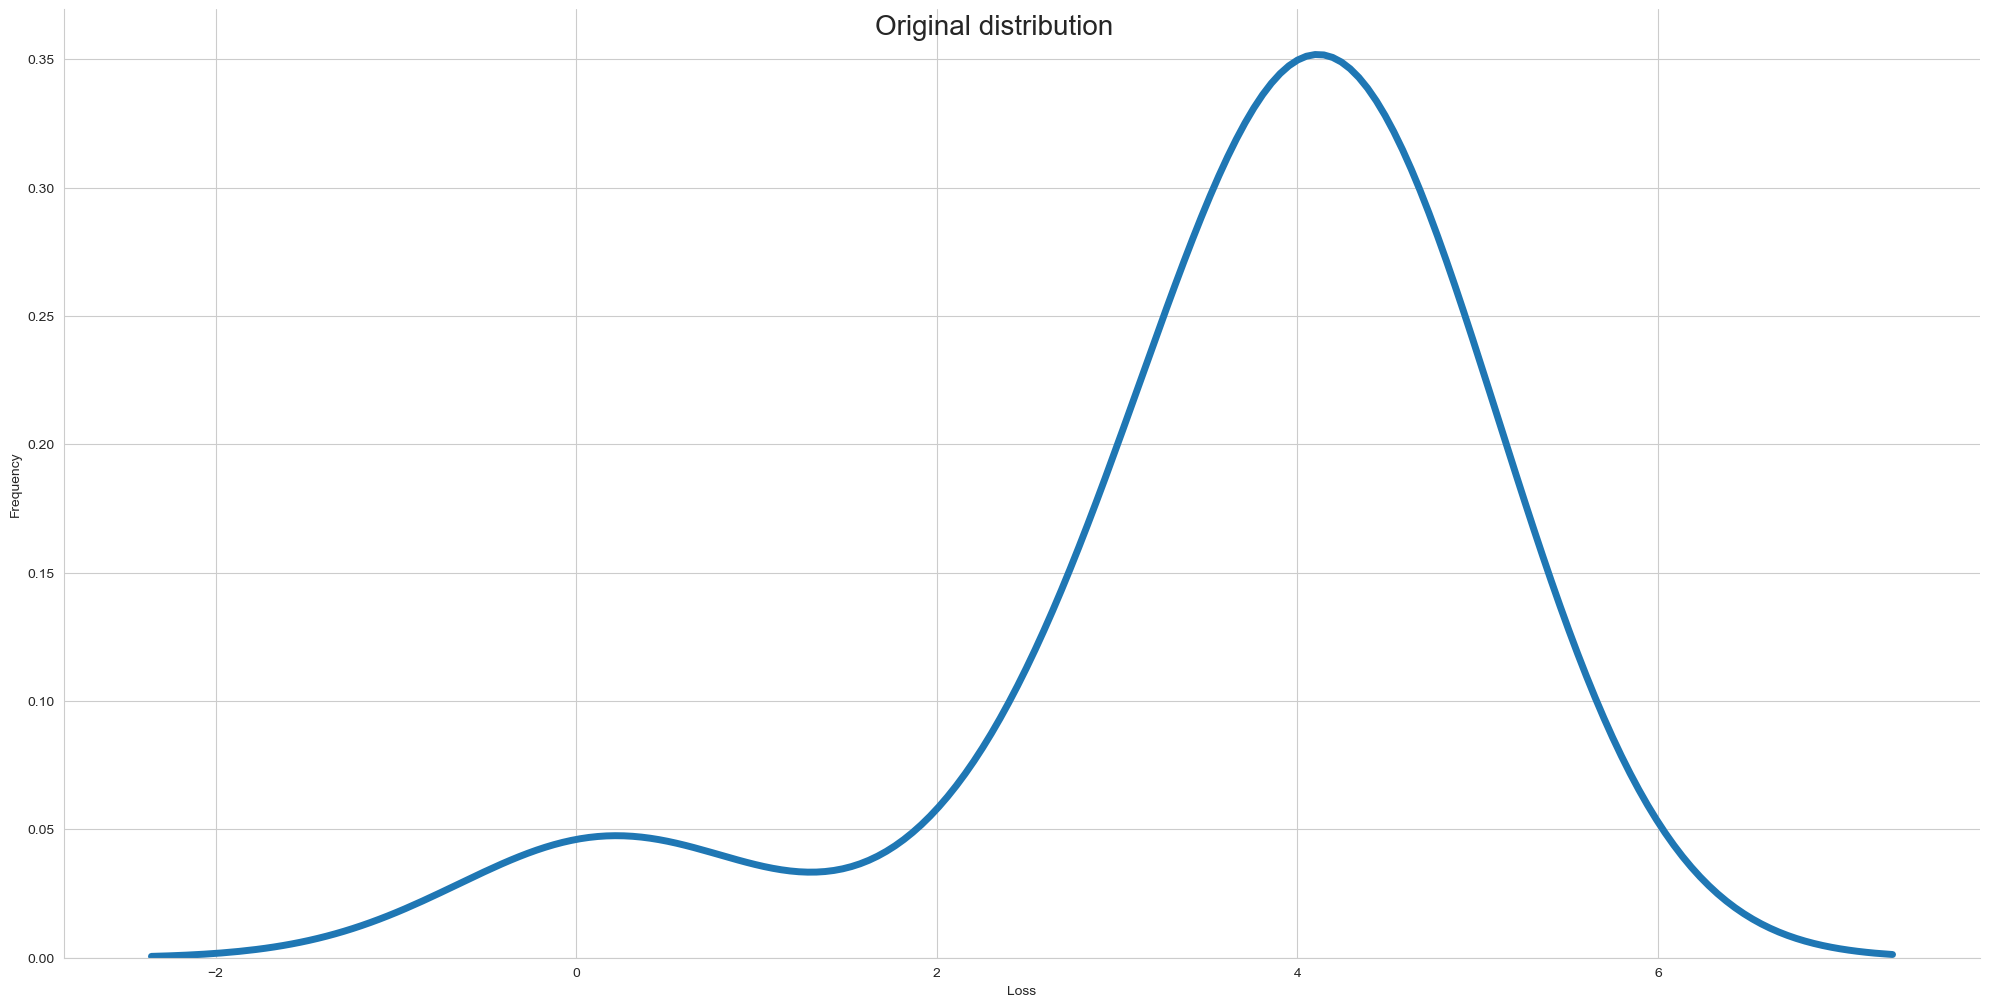

client_ 1  loss:  [0.60810548 0.49124789 0.42425817 0.38594407 0.36823279 0.35871762
 0.35395196 0.34909132 0.34512201 0.34348699] freq:  [ 38  72  80 100 154 175 210 265 301 304]


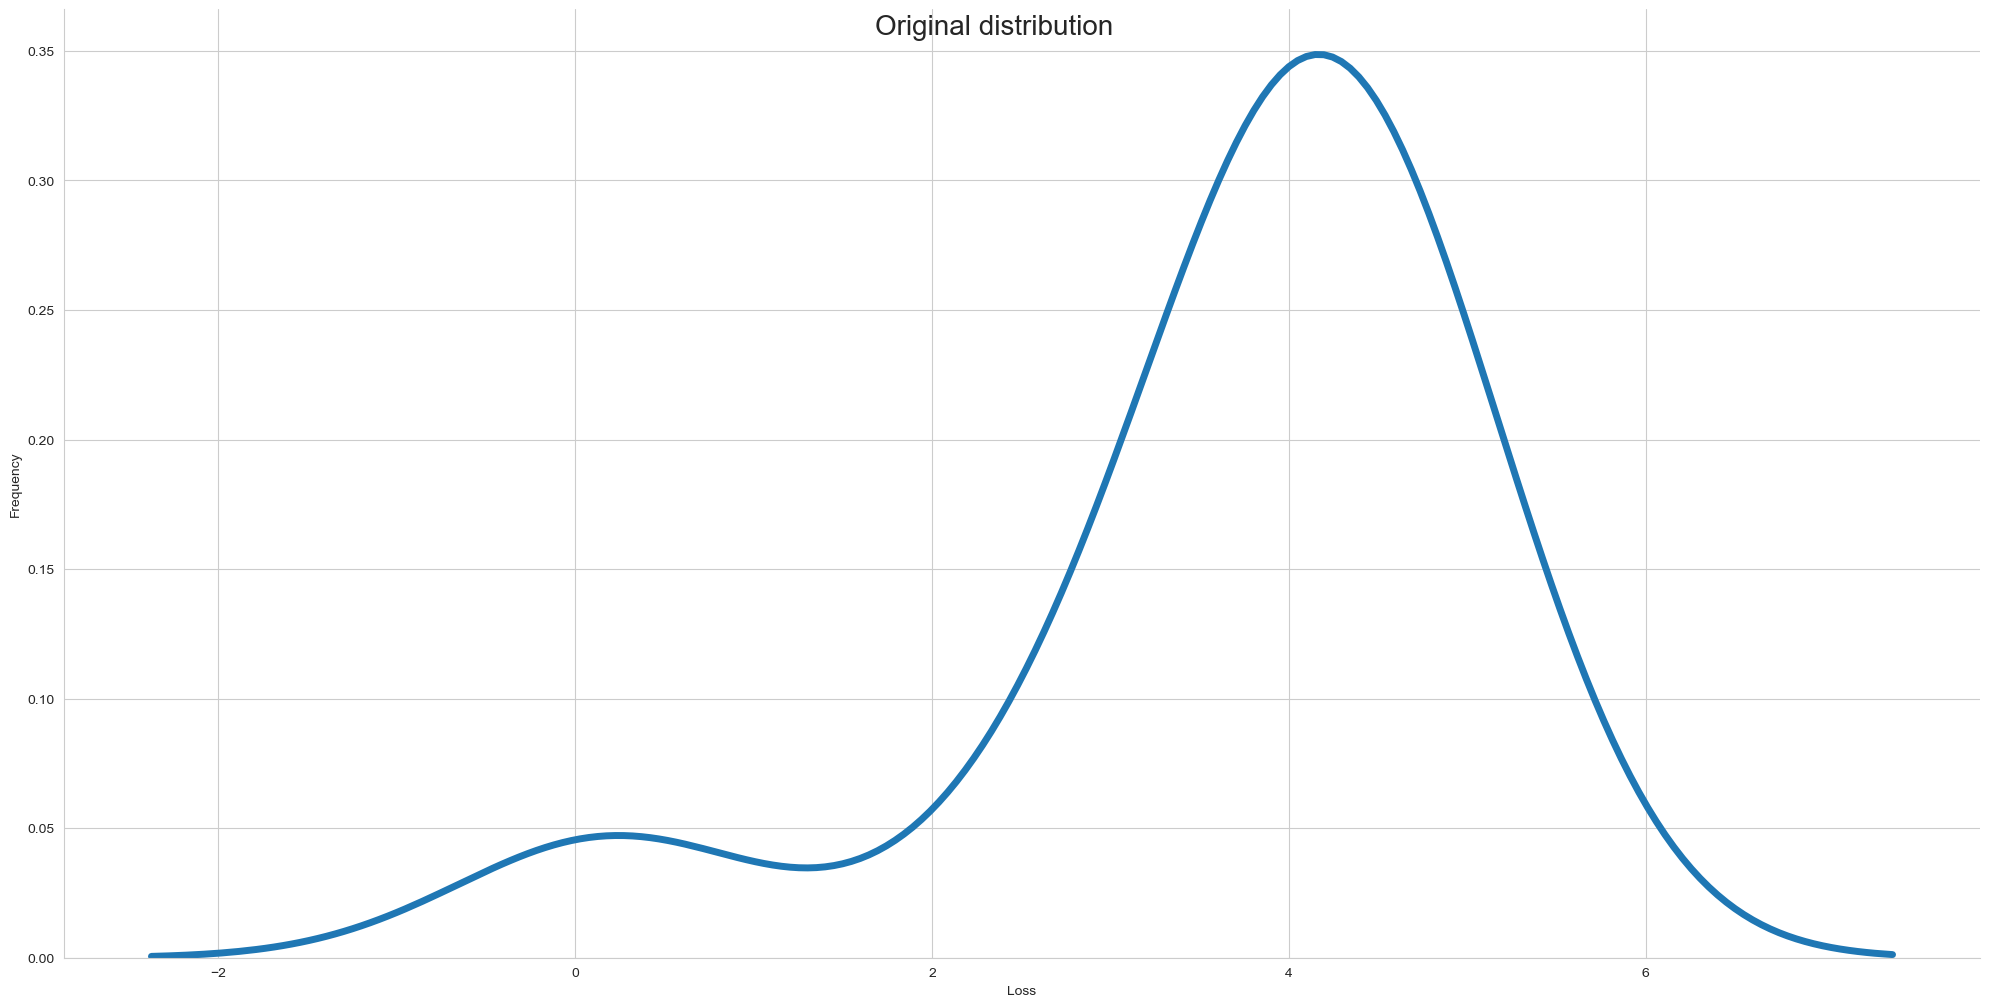

client_ 2  loss:  [0.62629861 0.5121786  0.42389324 0.38565096 0.36983481 0.3597762
 0.35359699 0.35081801 0.35046026 0.34585956] freq:  [ 26  28  61 119 128 167 202 222 248 308]


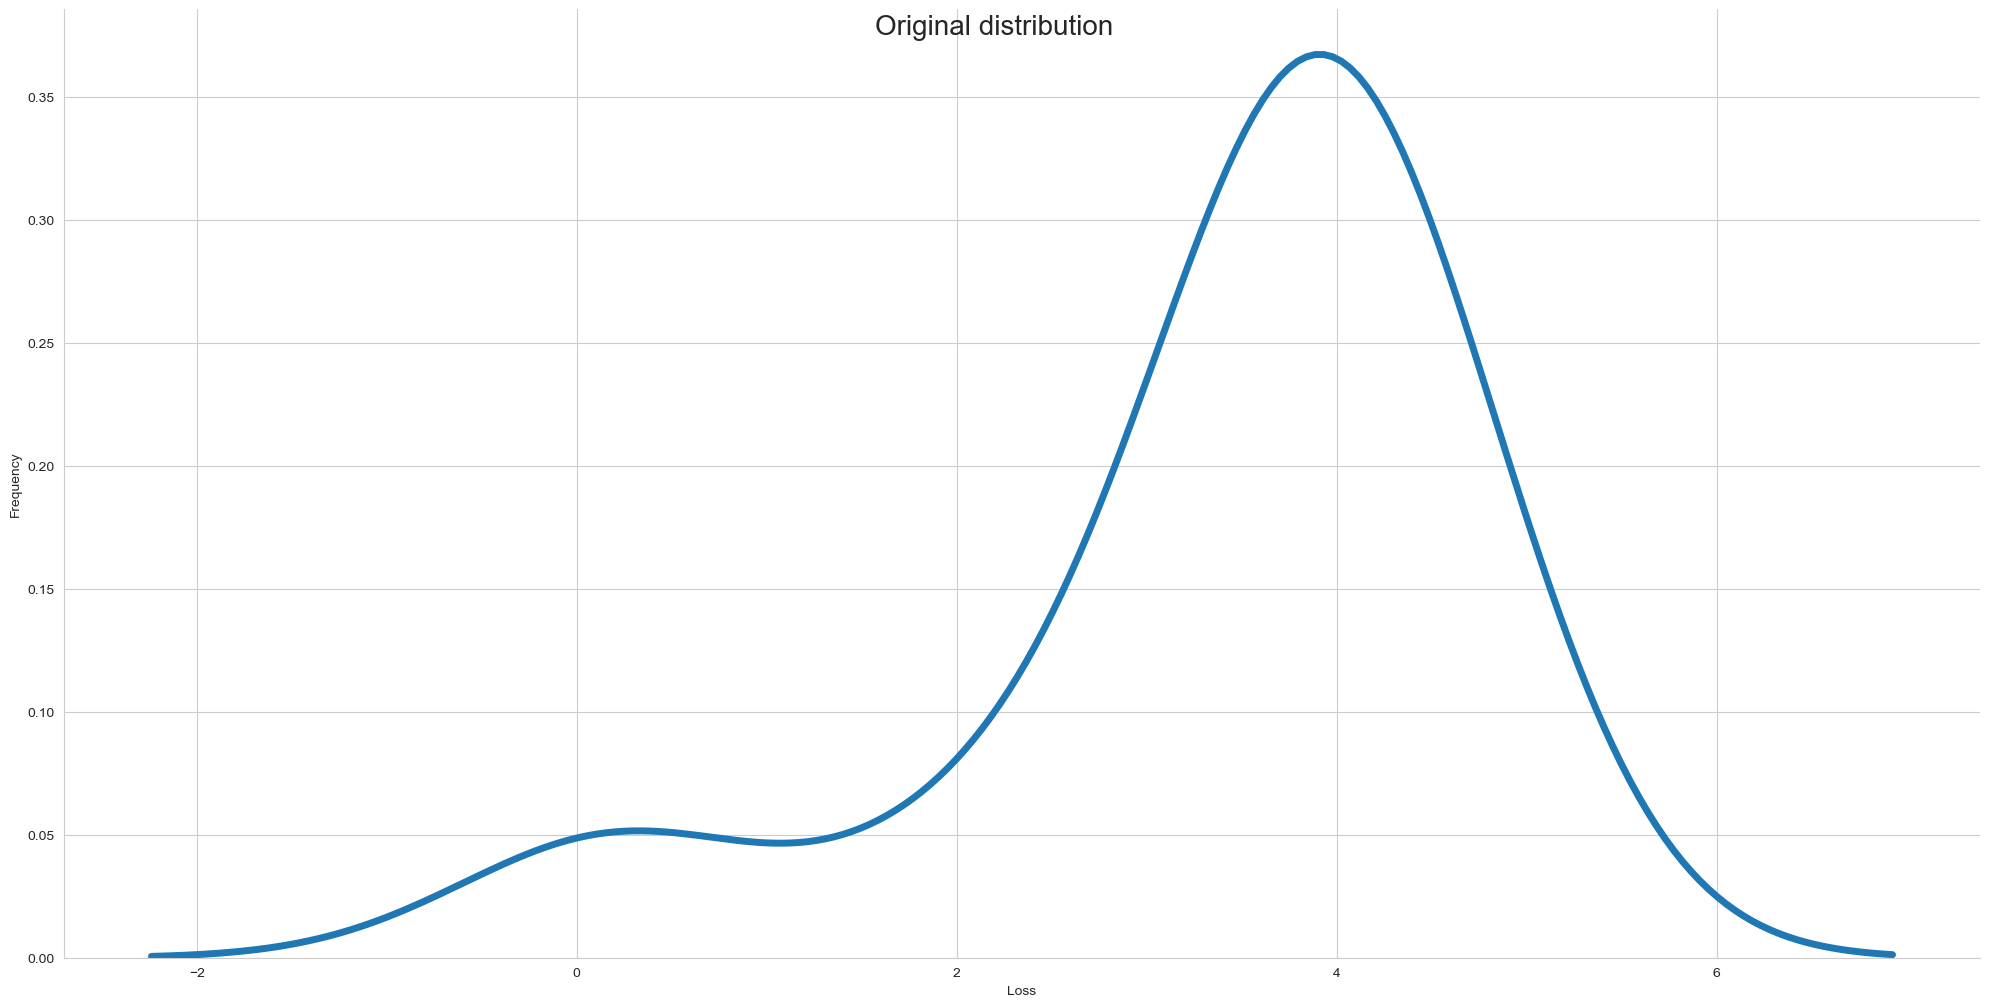

client_ 3  loss:  [0.5920248  0.47583362 0.42313868 0.3866969  0.37091368 0.36190581
 0.35488188 0.35127825 0.34916413 0.34639987] freq:  [ 49 102 104 119 124 138 185 201 215 265]


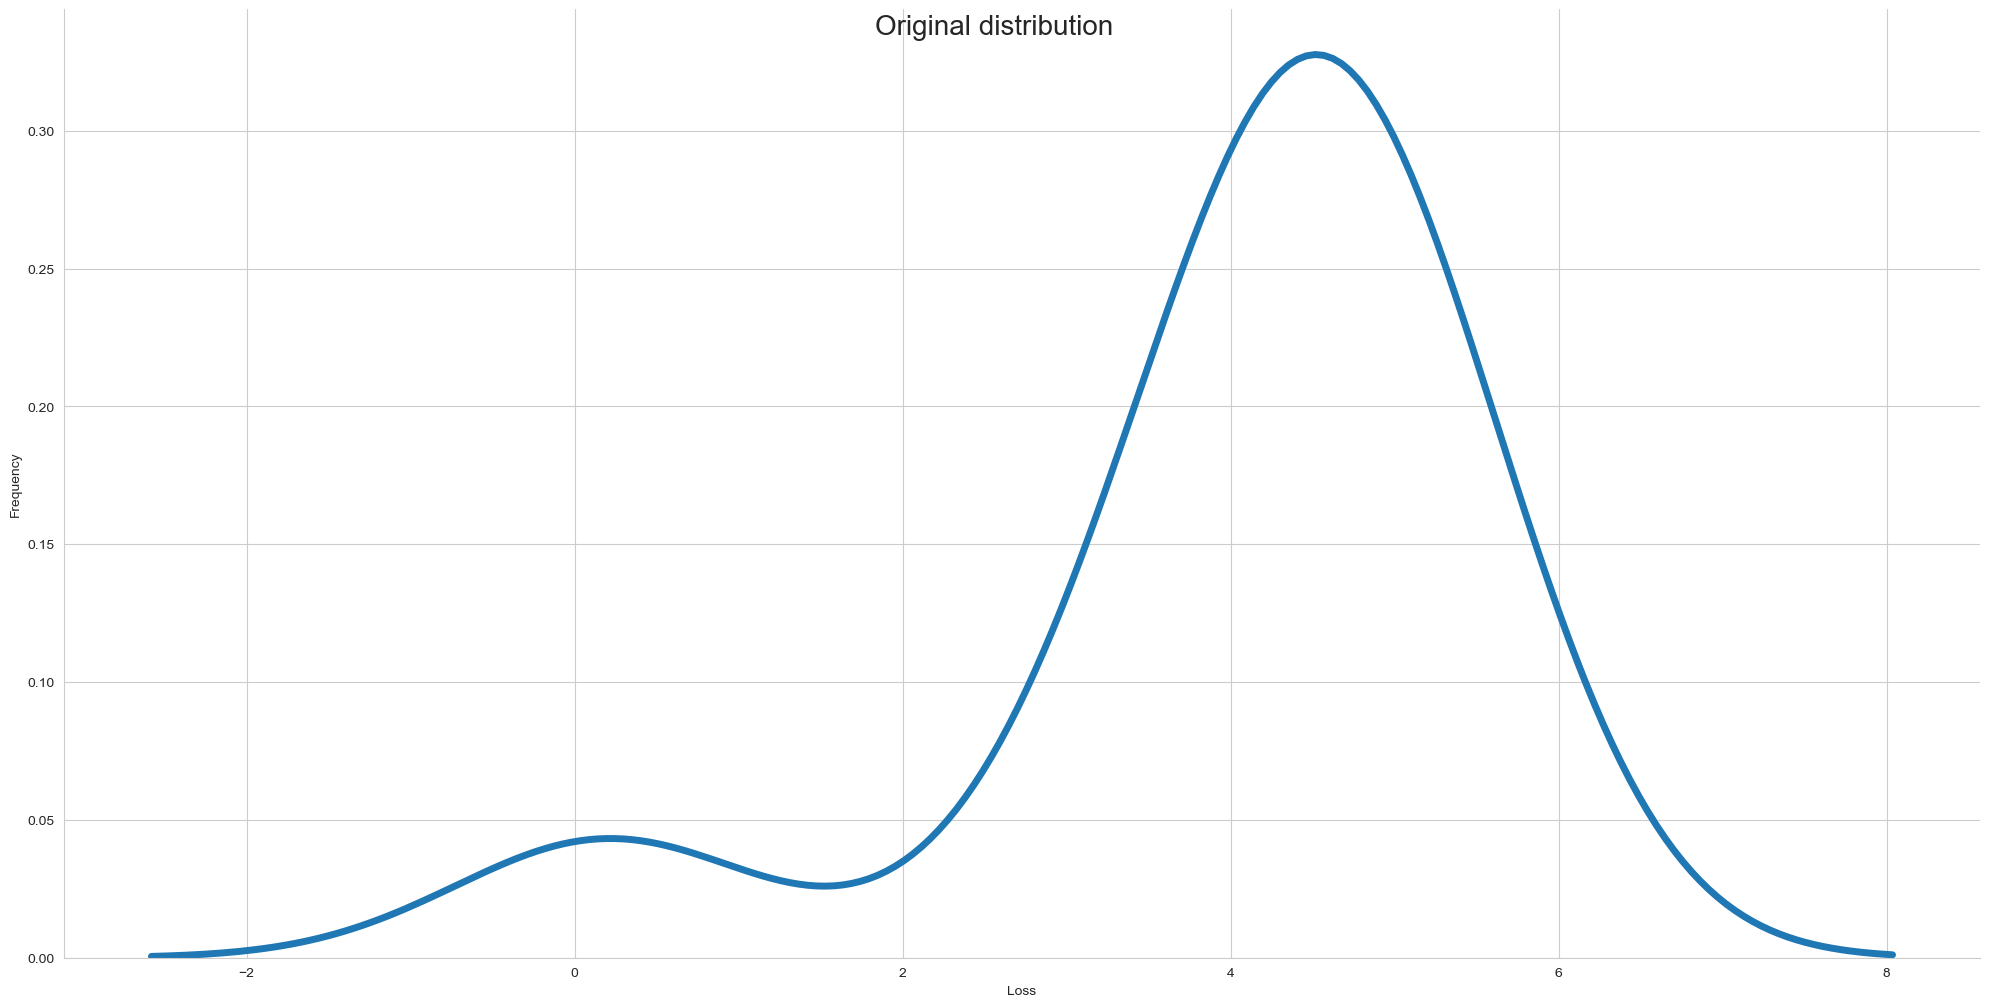

client_ 4  loss:  [0.65826589 0.5169788  0.42765966 0.38794741 0.36735302 0.35774747
 0.35061172 0.34742814 0.34490946 0.34517193] freq:  [ 11  26  53  78 123 172 209 224 249 315]


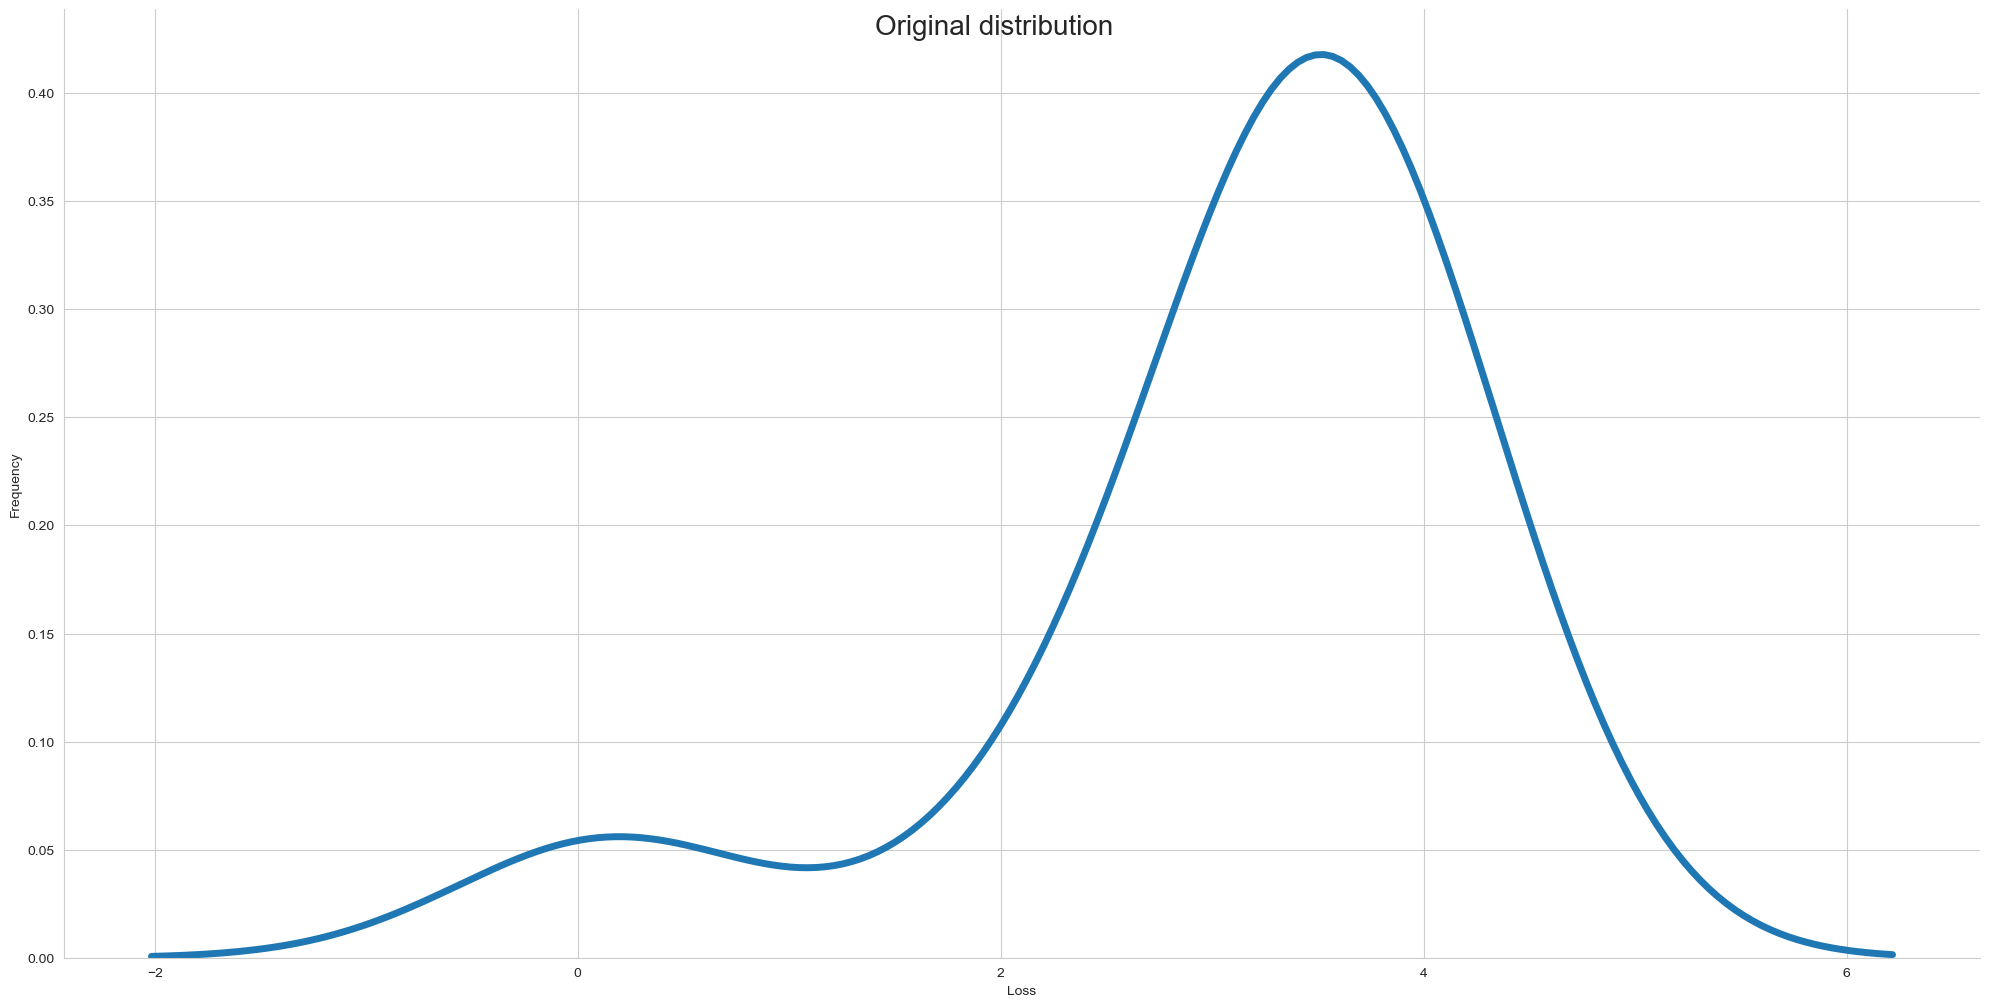

client_ 5  loss:  [0.61959428 0.48596308 0.40170121 0.37713358 0.3615804  0.35094073
 0.34597063 0.34304726 0.34170884 0.34019074] freq:  [ 31  74 155 190 254 301 345 408 456 501]


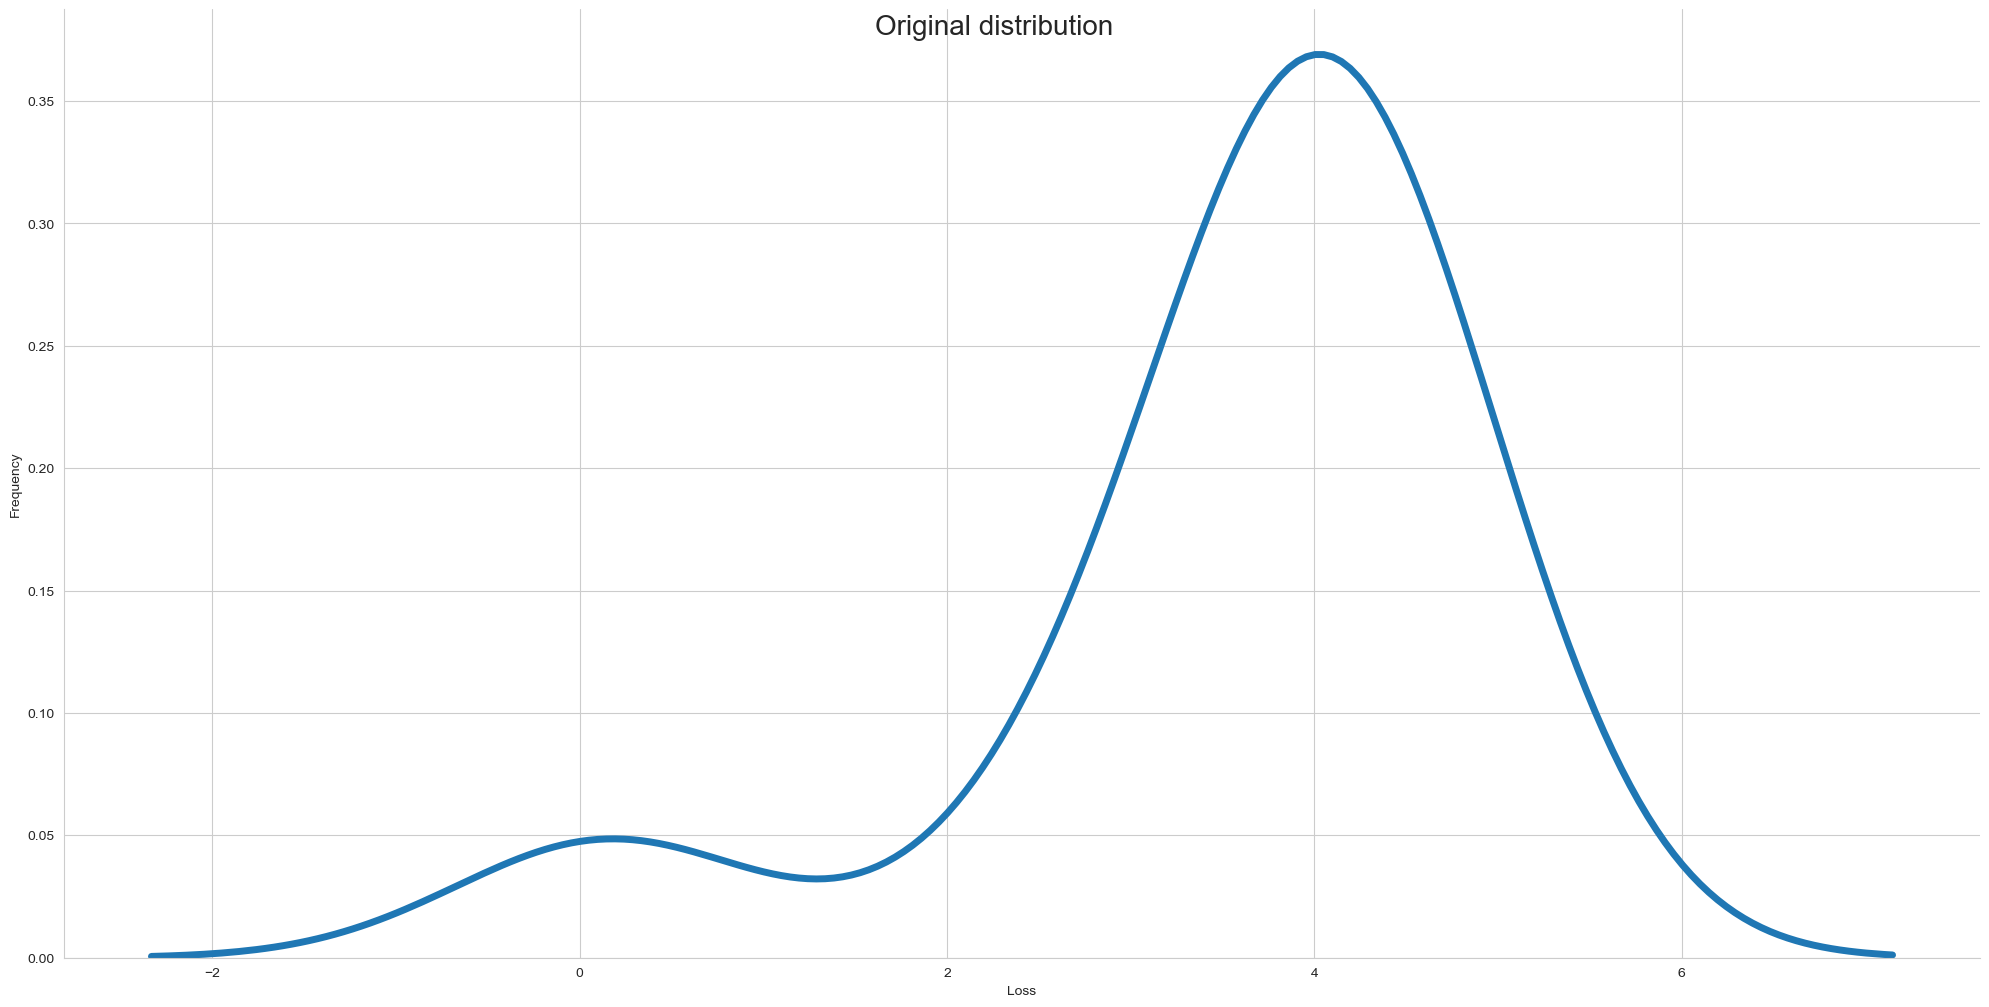

client_ 6  loss:  [0.63035935 0.5015859  0.4151603  0.3802737  0.36296323 0.35536006
 0.35027575 0.3468076  0.34330562 0.34104306] freq:  [ 23  48  91 135 164 209 225 248 287 306]


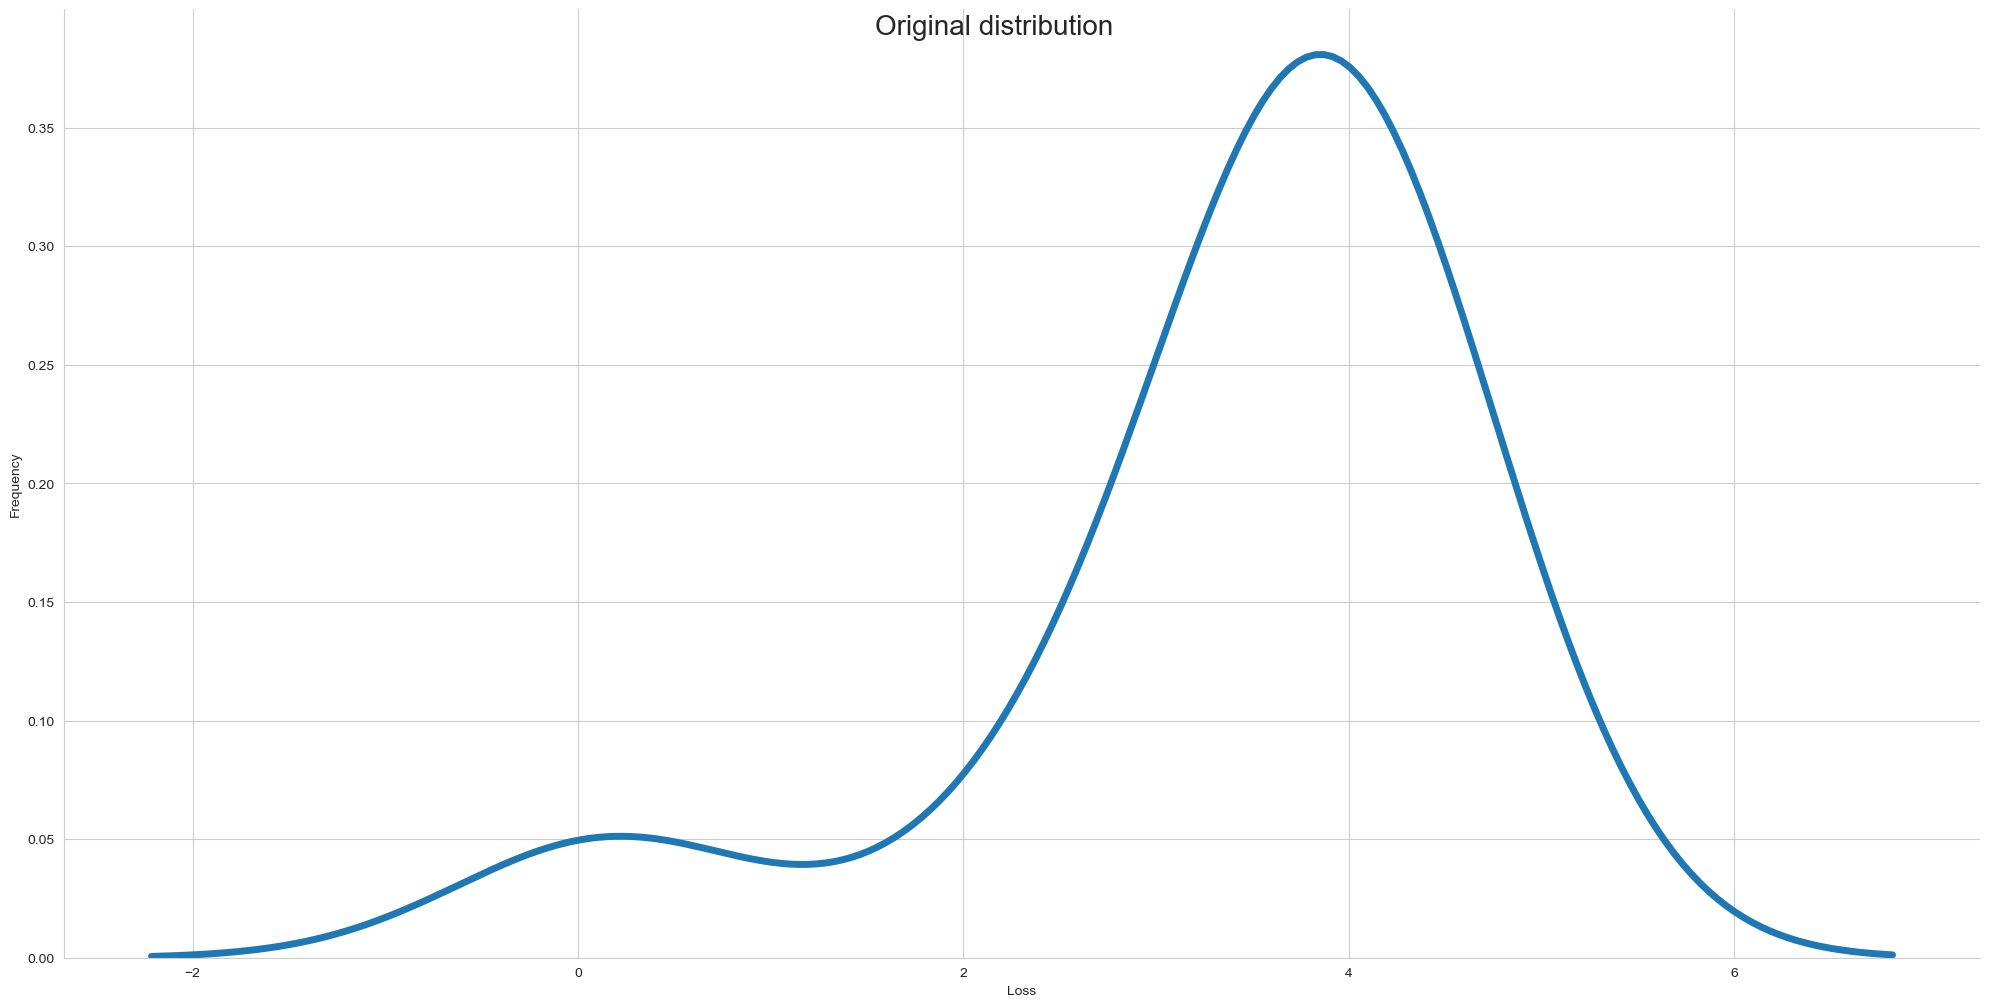

client_ 7  loss:  [0.67178184 0.51838964 0.42784214 0.38460797 0.36651531 0.358017
 0.35256788 0.34676394 0.34442586 0.34205738] freq:  [  2  27  40  91 124 172 187 232 261 263]


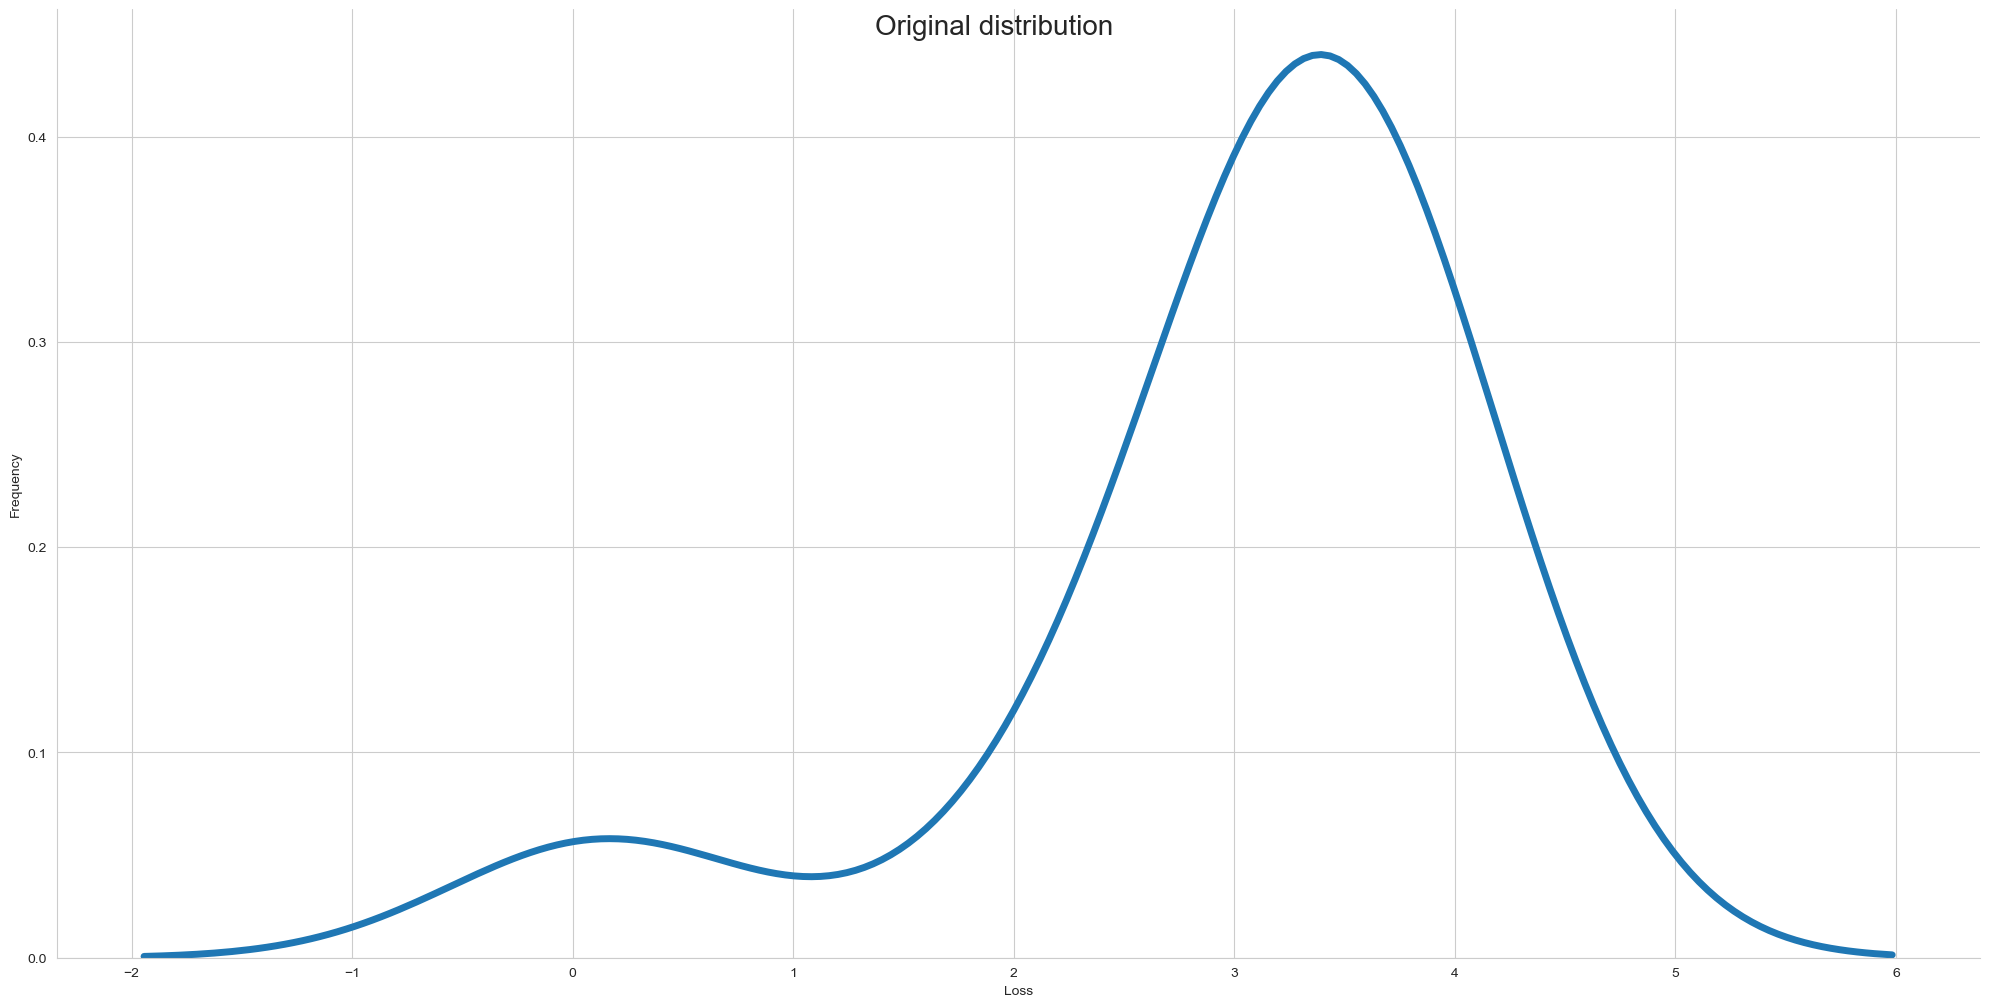

client_ 8  loss:  [0.58725697 0.49155888 0.41370627 0.38253722 0.36716944 0.35897282
 0.35035193 0.34639585 0.34351107 0.34077337] freq:  [ 51  64 112 133 145 158 187 200 215 222]


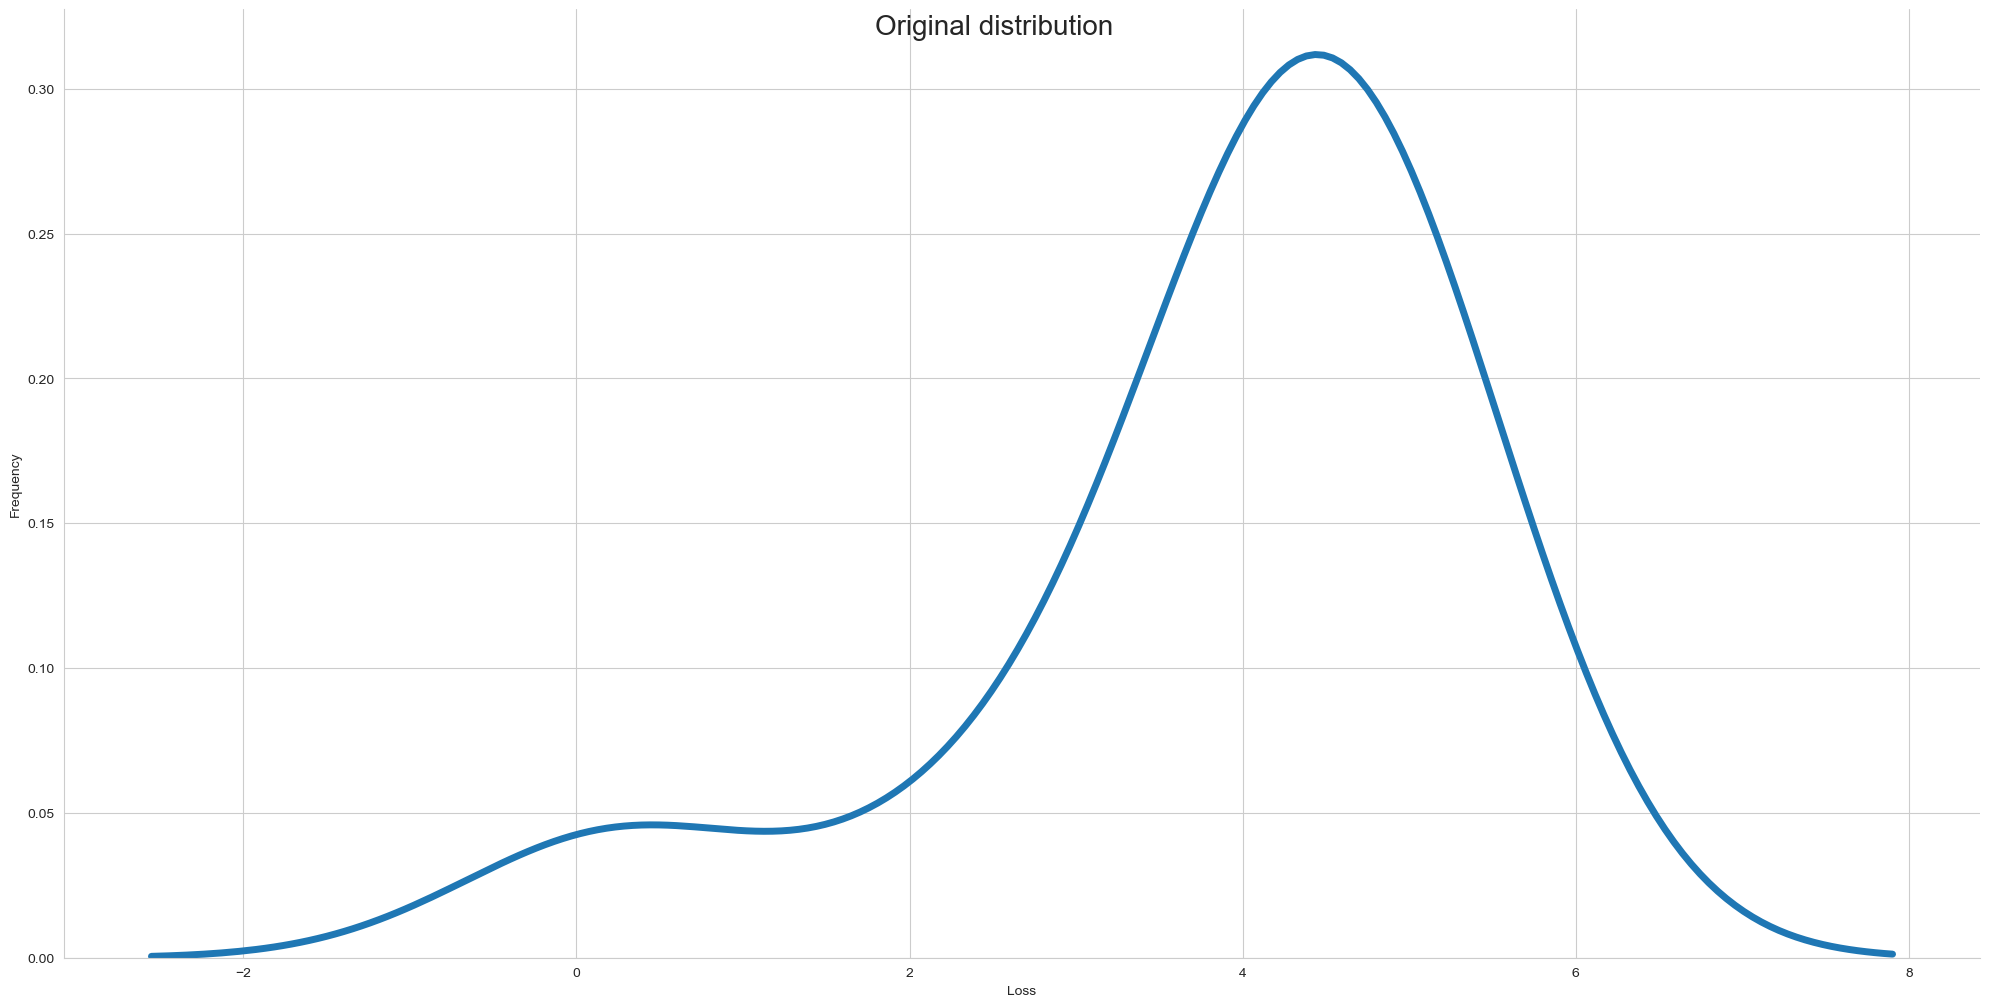

In [48]:
# 8 clients---> gender, race, income
pdfs = []
for i in list(client_loss.keys()):
    if(i== len(list(client_loss.keys()))-1):
        continue
    print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i])

#     shape, loc, scale = stats.gamma.fit(client_loss[i])
    
#     # Printing the estimated parameters
#     print("Shape:", shape)
#     print("Location:", loc)
#     print("Scale:", scale)
#     pdf = stats.gamma.pdf(client_loss[i], shape, loc=loc, scale=scale)
    
    
    df_mean = np.mean(client_loss[i])
    df_std = np.std(client_loss[i])
    pdf = stats.norm.pdf(client_loss[i], df_mean, df_std)
    pdfs.append(pdf)
    sns.set_style("whitegrid")

    ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
                linewidth = 5 )
    ax.fig.suptitle('Original distribution', size = 20)
    plt.ylabel("Frequency")
    plt.xlabel("Loss")
    plt.show()

In [49]:
for i in range(len(pdfs)):
    for j in range(i+1,len(pdfs)):
        print(i," and ", j , stats.wasserstein_distance(pdfs[i], pdfs[j]))

0  and  1 0.044831808719305914
0  and  2 0.23712636718944513
0  and  3 0.39372380670191687
0  and  4 0.5452293317281409
0  and  5 0.10166048784316714
0  and  6 0.2583336794104065
0  and  7 0.6480226441322103
0  and  8 0.2786794477373086
1  and  2 0.27146761046664963
1  and  3 0.35737562898179187
1  and  4 0.581577509448266
1  and  5 0.1131687511382619
1  and  6 0.2946818571305315
1  and  7 0.6843708218523353
1  and  8 0.23384763901800273
2  and  3 0.6288432394484414
2  and  4 0.31233390357293767
2  and  5 0.1673071239577643
2  and  6 0.059802665273666816
2  and  7 0.4154714937257373
2  and  8 0.4581190475827239
3  and  4 0.9389531384300577
3  and  5 0.47054438012005373
3  and  6 0.6520574861123233
3  and  7 1.041746450834127
3  and  8 0.18008769603862626
4  and  5 0.4688182148029108
4  and  6 0.28689565231773445
4  and  7 0.10313759015279962
4  and  8 0.7682289465643403
5  and  6 0.18441345880160886
5  and  7 0.5712020707140735
5  and  8 0.3455960326969811
6  and  7 0.38968896472180387

In [50]:
shape, loc, scale = stats.gamma.fit(global_loss_list)
pdf_global = stats.gamma.pdf(global_loss_list, shape, loc=loc, scale=scale)

for i in range(len(pdfs)):
    print(i," and global: " , stats.wasserstein_distance(pdfs[i], pdf_global))

0  and global:  551895867.5834975
1  and global:  551895867.5563524
2  and global:  551895867.7167867
3  and global:  551895867.3692136
4  and global:  551895868.0205219
5  and global:  551895867.6564797
6  and global:  551895867.7699083
7  and global:  551895868.1204396
8  and global:  551895867.3657157


In [51]:
# experiment plotter

# for i in list(client_loss.keys()):
#     if(i== len(list(client_loss.keys()))-1):
#         continue
#     print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i])
    
# #     df_mean = np.mean(client_loss[i])
# #     df_std = np.std(client_loss[i])
# #     pdf = stats.norm.pdf(client_loss[i], df_mean, df_std)

#     shape, loc, scale = stats.gamma.fit(client_loss[i])
    
#     # Printing the estimated parameters
# #     print("Shape:", shape)
# #     print("Location:", loc)
# #     print("Scale:", scale)
#     pdf = stats.gamma.pdf(client_loss[i], shape, loc=loc, scale=scale)

# #     plt.plot(client_loss[i], pdf, "-o", label = i)

# #     client_loss[i] = stats.gamma.rvs(1, size=5000)+5
#     sns.set_style("whitegrid")

#     ax = sns.displot( x = pdf, kind = "kde", height=10, aspect=2,
#                 linewidth = 5 )
#     ax.fig.suptitle('Original distribution', size = 20)
# #     plt.plot(client_loss[i], client_frequency[i], "-o", label = i)
# #     plt.legend()
#     plt.ylabel("Frequency")
#     plt.xlabel("Loss")
#     plt.show()

In [52]:
score = global_model.evaluate(X_test, y_test, verbose=0)
score

[0.364362895488739, 0.8335380554199219]

In [53]:
nn_preds = global_model.predict(X_test)
nn_preds = (nn_preds > 0.5)

nn_precision =precision_score(y_test, nn_preds)
nn_recall = recall_score(y_test, nn_preds)
nn_accuracy = accuracy_score(y_test, nn_preds)
nn_f1 = f1_score(y_test, nn_preds)


print("Precision = {}".format(nn_precision))
print("Recall = {}".format(nn_recall))
print("Accuracy = {}".format(nn_accuracy))
print("f1 = {}".format(nn_f1))


Precision = 0.7095292766934558
Recall = 0.5246179966044142
Accuracy = 0.8335380835380836
f1 = 0.603221083455344


In [54]:
arr = nn_preds > 0.5

unique, counts = np.unique(arr, return_counts=True)

np.asarray((unique, counts)).T

array([[   0, 8026],
       [   1, 1742]], dtype=int64)

In [55]:
# pdf for client losses
# x-loss
# y- frequency
# each client has one pdf for all rounds
# using histogram


# drop client
# non iid
# fedavg


# gender dist
# kernel density


# non-iid, loss to accuracy
# 4client